<hr style="height: 1px;">
<i>This notebook was authored by the 8.316 Course Team, Copyright 2023 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Lesson 4: Introduction to Data Fitting</h1>


<a name='section_4_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L4.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_1">L4.1 An Example: Hubble Constant</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_4_1">L4.1 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_2">L4.2 Derivation of Linear Regression</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_4_2">L4.2 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_3">L4.3 Linear Regression: Coding Example</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_4_3">L4.3 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_4">L4.4 Weighted Linear Regression</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_4_4">L4.4 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_5">L4.5 Minimization without the Math</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_4_5">L4.5 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_6">L4.6 Gradient Descent</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_4_6">L4.6 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_7">L4.7 Fitting the Full Range of Hubble Data</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_4_7">L4.7 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_8">L4.8 Fitting with lmfit</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_4_8">L4.8 Exercises</a></td>
    </tr>
</table>



<h3>Learning Objectives</h3>

In this Lesson, we will explore the following objectives:

- Linear Regression
- Weighted Linear Regression
- Minimizing without all of the math
- Gradient Descent: Actually understanding how we minimize numerically
- Optimized descent: The Newton Step

In the last Lesson, we introduced gravitational waves. Soon, you'll work on a project looking at real signals from LIGO. As part of that, you will need to fit a model to the data. 

What's fitting? Suppose you have a mathematical model that represents some physics phenomenon. It will have *parameters* that can be varies to adjust the output of the model. For example, the masses of black holes in a merger affect the waveform we expect from the resulting gravitational waves. Fitting is the process of coming up with parameter values that make your model output "best match" your observed data.

To quantify "best match" while fitting, we come up with a metric to measure how far the model output is from the data. Then, we work to **minimize** this error metric (which depending on context might be called "loss function" to minimize, "objective function" to maximize, etc.; I will use them interchangeably).

This minimization can be done analytically, which is a good exercise. That will be the first part of this lesson. However, for most complex data science projects, minimization is done numerically using computers. How this works will be discussed in the second part of the Lesson. Throughout, we'll be fitting some data to estimate the Hubble Constant, an important value in cosmology.

<h3>Importing Libraries and Data</h3>

Before beginning, run the cell below to import the relevant libraries for this notebook.


In [ ]:
#>>>RUN: L4.0-runcell01

!pip install lmfit

In [ ]:
#>>>RUN: L4.0-runcell02

#importing data from git repository

!git init
!git remote add -f origin https://github.com/mitx-8s50/nb_LEARNER/
!git config core.sparseCheckout true
!echo 'data/L04' >> .git/info/sparse-checkout
!git pull origin main

In [1]:
#>>>RUN: L4.0-runcell03

#import packages
import math as math                   #https://docs.python.org/3/library/math.html
import matplotlib.pyplot as plt       #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
import numpy as np                    #https://numpy.org/doc/stable/
import csv                            #https://docs.python.org/3/library/csv.html 
from scipy import stats               #https://docs.scipy.org/doc/scipy/reference/stats.html
from scipy.optimize import curve_fit  #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
import scipy.linalg as la             #https://docs.scipy.org/doc/scipy/reference/linalg.html
import lmfit                          #https://lmfit.github.io/lmfit-py/ 

<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.

In [2]:
#>>>RUN: L4.0-runcell04

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (7,4)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_4_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L4.1 An Example: Hubble Constant</h2>  

| [Top](#section_4_0) | [Previous Section](#section_4_0) | [Exercises](#exercises_4_1) | [Next Section](#section_4_2) |


<h3>Slides</h3>

Run the code below to view the slides for this section, which are discussed in the related video. You can also open the slides in a separate window <a href="https://mitx-8s50.github.io/slides/L04/slides_L04_01.html" target="_blank">HERE</a>.

In [ ]:
#>>>RUN: L4.1-slides

from IPython.display import IFrame
IFrame(src='https://mitx-8s50.github.io/slides/L04/slides_L04_01.html', width=975, height=550)

<h3>Slides</h3>

View the slides for this section below, which are discussed in the related video. You can also open the slides in a separate window <a href="https://mitx-8s50.github.io/slides/L04/slides_L04_01.html" target="_blank">HERE</a>.

<p align="center">
<iframe src="https://mitx-8s50.github.io/slides/L04/slides_L04_01.html" width="900", height="550" frameBorder="0"/>
</p>

<a name='exercises_4_1'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_1) | [Next Section](#section_4_2) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-4.1.1 Expansion and Recessional Velocity</span>

True or False: If the universe is expanding, the apparent recessional velocity of galaxies further away will be larger.


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

True

        
**EXPLANATION:**
        
Even if the recessional velocity of near and far galaxies may stay the same in their local frame, their observed recessional velocity will be different. Due to the expansion of the universe, space is also stretching, leading to galaxies further away having a larger apparent recessional velocity due to this expansion of space.

    
</div>


<a name='section_4_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L4.2 Derivation of Linear Regression</h2>  

| [Top](#section_4_0) | [Previous Section](#section_4_1) | [Exercises](#exercises_4_2) | [Next Section](#section_4_3) |


<h3>Supernova Data</h3>

For this class, we will use public data provided by the supernova galactic survey. This gives a list of supernovae along with their observed distances (with uncertainties) and their redshifts. These data are obtained through galactic observations of supernovae, with the line shifts indicating their respective redshift.

**Data Source**

We have included the data as a `.txt` file in the git repository. If using Colab, you will have downloaded the data in the initial steps of this Lesson.

The data are from https://supernova.lbl.gov/Union/. We have used the following file under "Cosmology Tables:"

- Union2.1 Compilation Magnitude vs. Redshift Table.

This table stores the name, redshift, distance modulus, and distance modulus error for a collection of supernovae. Feel free to also look around the rest of the website and see what people have done with the data!


**About the Data**

When loading the data, we need to know that the data is stored in terms of the distance modulus, $\mu$ defined <a href="https://en.wikipedia.org/wiki/Distance_modulus" target="_blank">here</a>. We can write this as 

$$
\begin{equation}
d=10^{\frac{\mu}{5} + 1}
\end{equation}
$$

Furthermore, the uncertainty $\sigma_{\mu}$ is also given in terms of the distance modulus. Given our relationship between the distance modulus and the distance, we can get the uncertainty in distance:

$$
\begin{eqnarray}
\sigma_{d} & = &  \frac{d}{d\mu}d(\mu) \cdot \sigma_{\mu} \\
           & = &  \frac{\log(10)}{5} 10^{\frac{\mu}{5} + 1}   \sigma_{\mu}
\end{eqnarray}
$$

With that in mind, let's go ahead and process the data. 

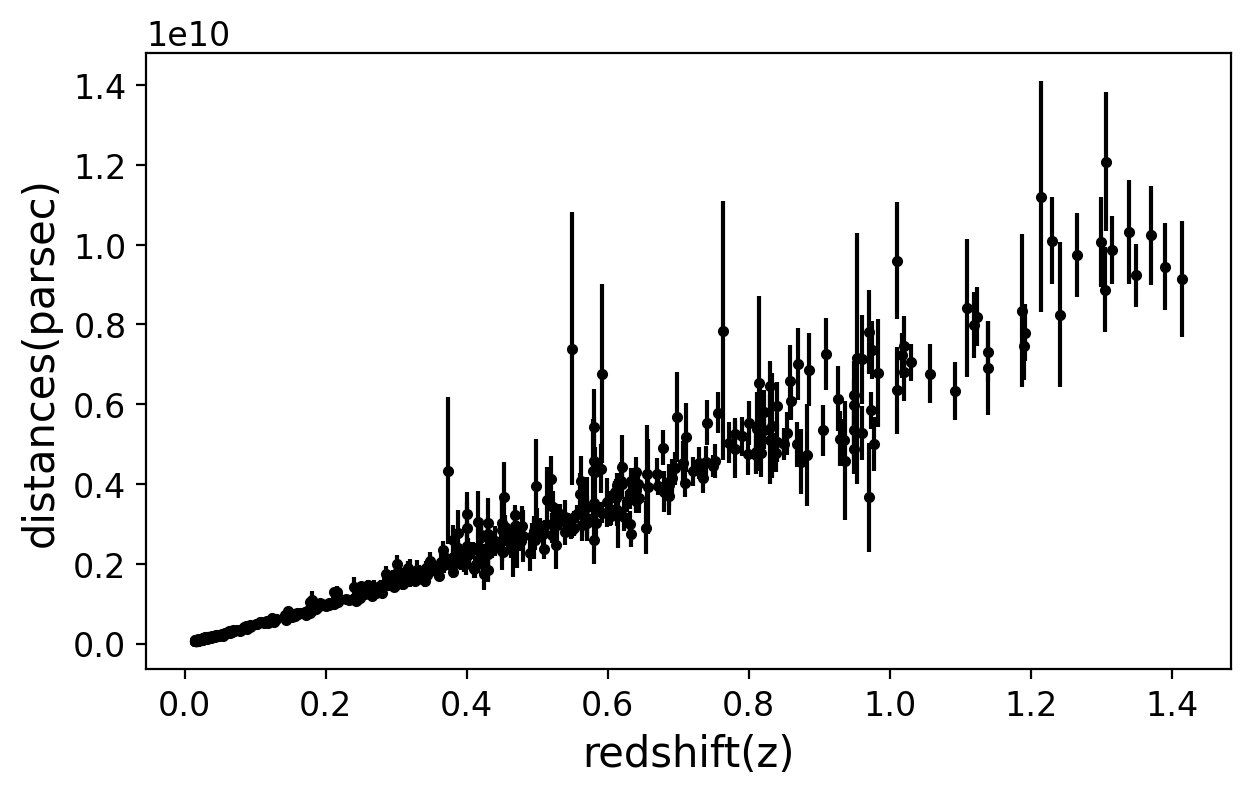

In [3]:
#>>>RUN: L4.2-runcell01

import math as math
import matplotlib.pyplot as plt
import numpy as np
import csv

#Today we are going to start with astro data from here : 
#http://supernova.lbl.gov/Union/
#Let's load the data

#label='data/L04/sn_z_mu_dmu_plow_union2.1.txt'
label='data/sn_z_mu_dmu_plow_union2.1.txt'


#Table stores name, redshift, distance modulus, distance modulus error
#Let's convert from distance modulus to distance
#See here https://en.wikipedia.org/wiki/Distance_modulus
def distanceconv(iMu):
    power=iMu/5+1
    return 10**power

# and the same for uncertainty in distance modulus to uncertainty in distance
def distanceconverr(iMu,iMuErr):
    power=iMu/5+1
    const=math.log(10)/5.
    return const*(10**power)*iMuErr

redshift=[]
distance=[]
distance_err=[]
# read in the data
with open(label,'r') as csvfile:
    plots = csv.reader(csvfile, delimiter='\t')
    # name, redshift, distance modulus, distance modulus uncertainty
    for row in plots:
        redshift.append(float(row[1]))
        distance.append(distanceconv(float(row[2])))
        distance_err.append(distanceconverr(float(row[2]),float(row[3])))

plt.xlabel('redshift(z)', fontsize=15) #Label x
plt.ylabel('distances(parsec)', fontsize=15)#Label y
# plot with errorbars
plt.errorbar(redshift,distance,yerr=distance_err,marker='.',linestyle = 'None', color = 'black')
plt.show()

This plot has an interesting shape. Instead of looking at the whole plot, we can zoom in on a specific region, namely the area with small redshifts: $z \lt 0.1$

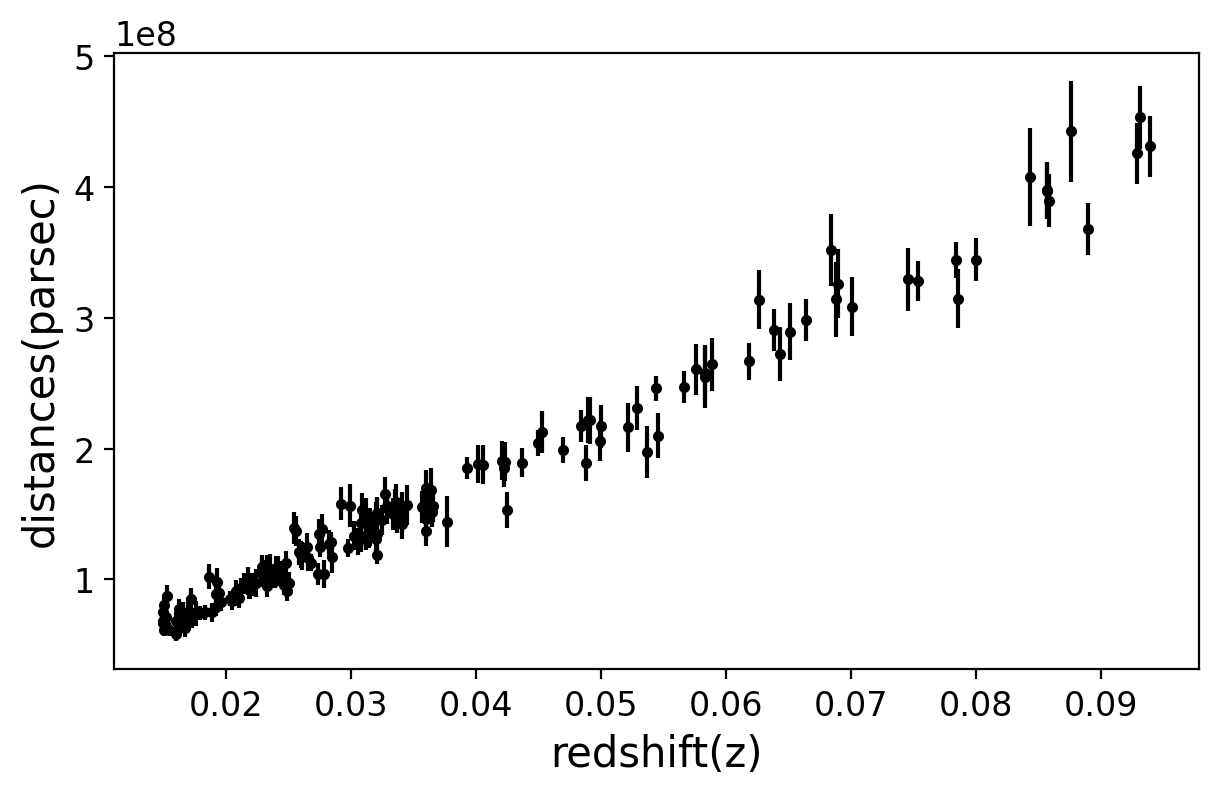

In [4]:
#>>>RUN: L4.2-runcell02

#Now let's zoom in on the small redshift data.
def load(iLabel,iZMax):
    # loads data from file iLabel with redshift below iZMax:
    redshift=[]
    distance=[]
    distance_err=[]
    with open(label,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter='\t')
        for row in plots:
            if float(row[1]) > iZMax:
                continue
            redshift.append(float(row[1]))
            distance.append(distanceconv(float(row[2])))
            distance_err.append(distanceconverr(float(row[2]),float(row[3])))
    return np.array(redshift), np.array(distance), np.array(distance_err)

redshift,distance,distance_err = load(label,0.1)
plt.xlabel('redshift(z)', fontsize=15) #Label x
plt.ylabel('distances(parsec)', fontsize=15)#Label y
plt.errorbar(redshift,distance,yerr=distance_err,marker='.',linestyle = 'None', color = 'black')
plt.show()

<h3>Linear (Least-Squares) Regression</h3>

The data above has what looks like a linear trend. So, we try fitting a linear model; that is, something of form

$$
\begin{equation}
y = Ax + b
\end{equation}
$$

In this case, $x$ is the redshift observed, and $y$ is the distance observed. The goal here is to extract the parameters $A$ and $b$ that make the model's output prediction match those of the data. We can do this analytically, with a somewhat involved derivation.

We start by defining $\hat{y}$, which is the model's prediction of $y$ based on $x$. Our data is a set of $x$ and $y$ values that we'll call $x_i$ and $y_i$. For each $x_i$, we'll get the corresponding prediction $\hat{y}_i$ from the model:

$$
\begin{equation}
\hat{y}_{i} = Ax_{i} + b
\end{equation}
$$

where now we vary $A$ and $b$ to make the model fit. As mentioned earlier, we need to define an objective—some function to measure error—then find parameters to minimize it.

What do we use for error? There are many possibilities. A common one is the square error: we take the difference between each predicted distance $\hat{y}_i$ and the corresponding observed distance $y_i$, and square it. Then we add those up over all our data points. We'll call this metric $Q$:

$$
\begin{eqnarray} 
Q & = & \sum_{i=1}^{N}\left(y_{i}-\hat{y}_{i}\right)^2 \\
Q & = & \sum_{i=1}^{N}\left(y_{i}-Ax_{i}-b\right)^2 \\
\end{eqnarray}
$$

where for the second line we've replaced $\hat{y}$ with the parameterization in our model. By the way, minimizing this particular type of $Q$ is what we call "least-squares" regression.

Now, the minimization step. We can take partial derivatives with respect to $A$ and to $b$ and set each to zero, to find extrema.

$$
\begin{eqnarray} 
\frac{\partial Q}{\partial A} & = & \sum_{i=1}^{N} -2 x_{i} \left(y_{i}-Ax_{i}-b\right) \\
              & = & \sum_{i=1}^{N} -2 \left(x_{i} y_{i}-Ax^{2}_{i}-b x_{i}\right) \\
              & = & 0
\end{eqnarray}          
$$

and for $b$ we have, noting that the average value of $x$ is $\bar{x}=\frac{1}{N} \sum_{i=1}^{N} x_{i}$ (and similar for $\bar{y}$), gives us

$$
\begin{eqnarray} 
\frac{\partial Q}{\partial b} & = & \sum_{i=1}^{N} -2  \left(y_{i}-Ax_{i}-b\right) \\
              & = & 2Nb + 2A\sum_{i=1}^{N}x_{i}-2\sum_{i=1}^{N}y_{i} \\
              & = & 0 \\
{\rm Rearranging,} \\
           b  & = & \frac{1}{N} \sum_{i=1}^{N}y_{i} - \frac{A}{N} \sum_{i=1}^{N}x_{i} \\
              & = & \bar{y} - A\bar{x}      
\end{eqnarray}          
$$

Since we have the data, we can easily calculate $\bar{x}$ and $\bar{y}$ and we have derived a formula for the optimal $b$ in terms of these two averages. (*It's good to keep in mind that the optimal $A$ and $b$ that we find here are only optimal in the sense that they minimize our choice of function $Q$, giving the least-squares fit. If we had a different measure of error, our results might be different.*)



Now, we can go back and solve for $A$, by substituting in our optimal $b$. This gives us

$$
\begin{eqnarray} 
\frac{dQ}{dA} & = & \sum_{i=1}^{N} -2 \left(x_{i} y_{i}-Ax^{2}_{i}-\left(\bar{y} - A\bar{x}\right) x_{i}\right) \\
              & = & \sum_{i=1}^{N} -2 \left(x_{i} y_{i}-x_{i}\bar{y}-Ax^{2}_{i}+ A\bar{x}x_{i}\right) \\                           & = & -2 \sum_{i=1}^{N} x_{i}\left( y_{i}-\bar{y}\right)+2A\sum_{i=1}^{N} x_{i}\left(x_{i}-\bar{x}\right) \\
              & = & 0 \\
{\rm Solving} \\
A & = & \frac{\sum_{i=1}^{N} x_{i}\left( y_{i}-\bar{y}\right)}{\sum_{i=1}^{N} x_{i}\left(x_{i}-\bar{x}\right)} \\
  & = & \frac{\sum_{i=1}^{N} x_{i}\left( y_{i}-\bar{y}\right) +\sum_{i=1}^{N}\left(\bar{x}\bar{y}-y_{i}\bar{x}\right)}      
  {\sum_{i=1}^{N} x_{i}\left(x_{i}-\bar{x}\right) + \sum_{i=1}^{N}\left(\bar{x}^2-x_{i}\bar{x}\right)} \\
  & = & \frac{\sum_{i=1}^{N} \left( x_{i} y_{i}-x_{i}\bar{y}+\bar{x}\bar{y}-y_{i}\bar{x}\right)}      
  {\sum_{i=1}^{N} \left(x^2_{i}-x_{i}\bar{x} + \bar{x}^2-x_{i}\bar{x}\right)} \\
  & = & \frac{\frac{1}{N}\sum_{i=1}^{N} \left(x_{i} - \bar{x} \right) \left(y_{i}-\bar{y}\right)}      
             {\frac{1}{N}\sum_{i=1}^{N} \left(x_{i}-\bar{x}\right)^2}\\
\end{eqnarray} 
$$

Ok, that's a lot of math, but in the end we get an explicit formula for the optimal $A$. To make things look cleaner, we can break the above into a few functions. We define the covariance and variance as: 

$$
\begin{eqnarray} 
\rm{VAR(x)}   & = & \frac{1}{N}\sum_{i=1}^{N} \left(x_{i}-\bar{x}\right)^2 \\
\rm{COV(x,y)} & = & \frac{1}{N}\sum_{i=1}^{N} \left(x_{i} - \bar{x} \right) \left(y_{i}-\bar{y}\right) \\
            A & = & \frac{\rm{COV(x,y)}}{\rm{VAR(x)}}
\end{eqnarray}
$$

We'll talk about the covariance later. The variance is just the variance we defined on the first Lesson, but now in discrete form. Alright, now let's code this guy up!

<a name='exercises_4_2'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_2) | [Next Section](#section_4_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-4.2.1 Complete the Derivation</span>

In the derivation shown previously, how did we get the strange formulation in that second step? Part of the answer is that we could add a term $\sum_{i} x_{i}\bar{x} - \bar{x}^2$ to the denominator because $\sum_{i} x_{i}\bar{x} - \bar{x}^2 = 0$. This helped simplify the derivation. Below, we show a partial proof that $\sum_{i} x_{i}\bar{x} - \bar{x}^2 = 0$:

<br>

$$
\begin{eqnarray} 
\sum_{i} (x_{i}\bar{x}-\bar{x}^{2}) & = & \sum_{i} x_{i}\bar{x} -\sum_{i} \bar{x}^{2} \\
& = & [\mathrm{insert\,missing\,step}]\\
& = & 0 \\
\end{eqnarray}
$$  

<br>

In order for this to be true, what must the value of $\sum_{i} x_{i}\bar{x}$ be? Express your answer in terms of `N` for $N$ and `xbar` for $\bar{x}$.


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

$$
\begin{eqnarray} 
\sum_{i} (x_{i}\bar{x}-\bar{x}^{2}) & = & \sum_{i} x_{i}\bar{x} -\sum_{i} \bar{x}^{2} \\
& = & \bar{x}\sum_{i} x_{i} -N\bar{x}^{2}\\
& = & \bar{x}N\bar{x}-N\bar{x}^{2} \\
& = & 0 \\
\end{eqnarray}
$$  
  
**EXPLANATION:**
    
See above.
    
</div>


<a name='section_4_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L4.3 Linear Regression: Coding Example</h2>  

| [Top](#section_4_0) | [Previous Section](#section_4_2) | [Exercises](#exercises_4_3) | [Next Section](#section_4_4) |


*The material in this section is discussed in the video **<a href="https://courses.mitxonline.mit.edu/learn/course/course-v1:MITxT+8.S50.1x+3T2022/block-v1:MITxT+8.S50.1x+3T2022+type@sequential+block@seq_LS4/block-v1:MITxT+8.S50.1x+3T2022+type@vertical+block@vert_LS4_vid3" target="_blank">HERE</a>.** You are encouraged to watch that video and use this notebook concurrently.*

<h3>Overview</h3>


Now, it's time to run the linear regression we mathematically derived in the section above! Below is an implementation of regression based on our calculation, and the units are explained following this implementation.


Hubbles Constant: 65.87381819553848 intercept -3931446.778206587


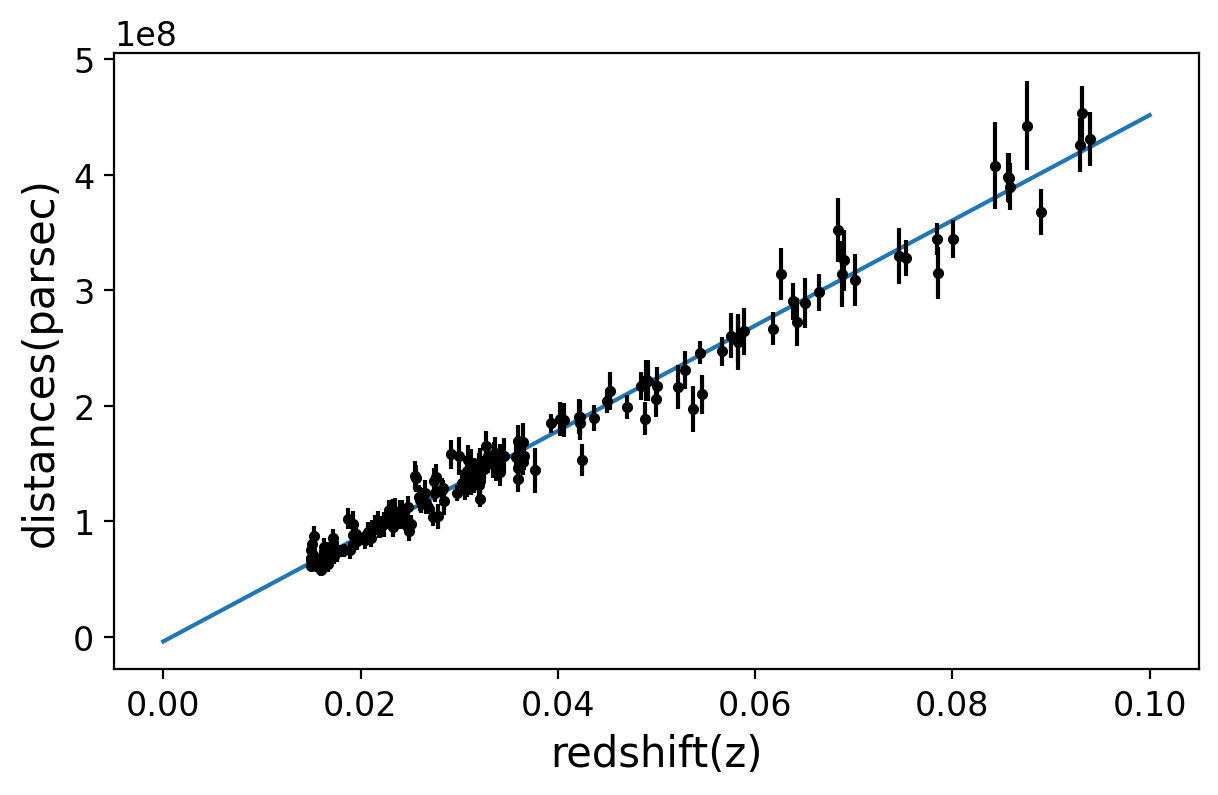

In [8]:
#>>>RUN: L4.3-runcell01

#Let's run the regression again
def variance(isamples):
    mean=isamples.mean()
    n=len(isamples)
    tot=0
    for pVal in isamples:
        tot+=(pVal-mean)**2
    return tot/n

def covariance(ixs,iys):
    meanx=ixs.mean()
    meany=iys.mean()
    n=len(ixs)
    tot=0
    for i0 in range(len(ixs)):
        tot+=(ixs[i0]-meanx)*(iys[i0]-meany)
    return tot/n

def linear(ix,ia,ib):
    return ia*ix+ib

def regress(redshift,distance):
    #Let's regress
    var=variance(redshift)
    cov=covariance(redshift,distance)
    A=cov/var
    b=distance.mean()-A*redshift.mean()
    #Done!
    return A,b

def plotAll(redshift,distance,distance_err,A,b):
    #now let's plot it
    xvals = np.linspace(0,0.1,100)
    yvals = []
    for pX in xvals:
        yvals.append(linear(pX,A,b))

    #Plot the line
    plt.plot(xvals,yvals)
    plt.errorbar(redshift,distance,yerr=distance_err,marker='.',linestyle = 'None', color = 'black')
    plt.xlabel('redshift(z)', fontsize=15) #Label x
    plt.ylabel('distances(parsec)', fontsize=15)#Label y
    #plt.show()
    #Print it out
    print("Hubbles Constant:",1e6*3e5/A,"intercept",b)#Note 1e6 is from pc to Mpc and 3e5 is c in km/s

A,b=regress(redshift,distance)
plotAll(redshift,distance,distance_err,A,b)
plt.show()

From the data we're fitting, we can figure out the units of the slope $A$ :

$$A = \frac{\rm distance(pc) }{\rm  Redshift~(z)}$$

where the redshift $z$ is the fractional (dimensionless) change in wavelength. Hubble's constant is defined as

$$h_{0} = \frac{\rm Recession\, speed~(km/s)}{\rm distance(Mpc)}$$ 

For nonrelativistic speeds, the magnitude of redshift roughly corresponds to the recession speed by $z\approx v/c$. So, we do the unit conversions to obtain

$$h_{0} = \frac{1}{A}\frac{\rm c~(km/s)}{10^{-6}}=\frac{1}{A}\frac{\rm 3\times10^{5}~(km/s)}{10^{-6}} $$

<a name='exercises_4_3'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_3) | [Next Section](#section_4_4) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-4.3.1 Uncertainty in $h_{0}$</span>

Now we wish to obtain the uncertainty on $h_{0}$, which we call $\sigma_{h_0}$, where we will use the definition:

$$h_{0} =\frac{1}{A}\frac{\rm 3\times10^{5}~(km/s)}{10^{-6}} $$


Assume that we know the uncertainty on $A$, which we call $\sigma_{A}$. What is the value of $\sigma_{h_0}$? Express your answer in terms of `A` for $A$, `h_0` for $h_{0}$, and `sigma_A` for $\sigma_{A}$.

**Hint: To answer this question, you need to use propagation of uncertainty!**

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**


$$\sigma_{h_0} = \frac{h_{0}}{A} \sigma_{A}$$  
    
 
**EXPLANATION:**
    
We know the functional form of the dependence of $h_0$ on $A$; $h_0(A)=f(A)=C/A$, where $C$ is the numerical factor shown above. For a function of a random variable, we know the uncertainty scales approximately with the derivative in this fashion.
    
$$
\begin{eqnarray} 
f(A) & = & \frac{C}{A},\\ 
\frac{df}{dA} & = & -\frac{C}{A^2},\\
\sigma_{f} & = & \left | \frac{df}{dA} \right | \sigma_{A} \\
\sigma_{h_0} & = \frac{C}{A^2} \sigma_{A} \\
\end{eqnarray}
$$  
    
This is the functional dependence on $A$. In terms of $h_{0}$, we have:
    
$$\sigma_{h_0} = \frac{h_{0}}{A} \sigma_{A}$$  
    
</div>


>#### Follow-up 4.3.1a (ungraded)
>
>What is the uncertainty $\sigma_{h_0}$ written only in terms of the slope $A$ and its uncertainty? 


<a name='section_4_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L4.4 Weighted Linear Regression</h2>  

| [Top](#section_4_0) | [Previous Section](#section_4_3) | [Exercises](#exercises_4_4) | [Next Section](#section_4_5) |


*The material in this section is discussed in the video **<a href="https://courses.mitxonline.mit.edu/learn/course/course-v1:MITxT+8.S50.1x+3T2022/block-v1:MITxT+8.S50.1x+3T2022+type@sequential+block@seq_LS4/block-v1:MITxT+8.S50.1x+3T2022+type@vertical+block@vert_LS4_vid4" target="_blank">HERE</a>.** You are encouraged to watch that video and use this notebook concurrently.*

<h3>Overview</h3>

Each measurement of some variable $y$ carries an uncertainty $\sigma_{y}$. 

*How the uncertainty is actually computed depends on the experiment. However, the uncertainty is **supposed** to correspond to the RMS of the measured value. In other words, if we perform the same measurement $N$ times, the variance of those measured values $y_{i}$ will be $V[y]=\sigma^2_{y}$.* More precisely, the variance  should approach $\sigma^{2}_{y}$ as we increase $N$.

We can define a metric to minimize that accounts for the fact that different measurements can have larger or smaller uncertainties. 

$$
\begin{eqnarray} 
Q & = & \sum_{i=1}^{N}\frac{\left(y_{i}-\hat{y}_{i}\right)^2}{\sigma^{2}_{y_{i}}} \\
Q & = & \sum_{i=1}^{N}\frac{\left(y_{i}-Ax_{i}-b\right)^2}{\sigma^{2}_{y_{i}}} \\
\end{eqnarray}
$$

Note that if all of the uncertainties $\sigma_{y_{i}}$ are the same, this is just a constant times the $Q$ we defined earlier and therefore setting the derivative to zero will give exactly the same answer as before.

What does this do? For any $y_i$ that has a large uncertainty, the corresponding contribution to the metric $Q$ is scaled down, since we trust it less. We can now follow the same procedure as before and minimize this adjusted metric with respect to $A$ and $b$, yielding the following: 

$$
\begin{eqnarray} 
\frac{\partial Q}{\partial A} & = & \sum_{i=1}^{N} -2 \frac{x_{i}}{\sigma_{i}^2} \left(y_{i}-Ax_{i}-b\right) \\
              & = & \sum_{i=1}^{N} -2 \frac{1}{\sigma_{i}^2} \left(x_{i} y_{i}-Ax^{2}_{i}-b x_{i}\right) \\
              & = & 0
\end{eqnarray}          
$$

and 

$$
\begin{eqnarray} 
\frac{\partial Q}{\partial b} & = & \sum_{i=1}^{N} -2  \frac{1}{\sigma_{i}^2} \left(y_{i}-Ax_{i}-b\right) \\
              & = & 2Nb\sum_{i=1}^{N}\frac{1}{\sigma_{i}^2} + 2A\sum_{i=1}^{N} \frac{x_{i}}{\sigma_{i}^2} -2\sum_{i=1}^{N}\frac{y_{i}}{\sigma_{i}^2} \\
              & = & 0 \\
\end{eqnarray}          
$$

From this, we can draw an analogy to the previous derivation, and write the answer given by reparametrizing in terms of the weighted mean defined as 

$$
\begin{eqnarray} 
 \bar{y}_{w} & = & \frac{\sum_{i=1}^{N} \frac{y_{i}}{\sigma_{i}^2} }{\sum_{i=1}^{N} \frac{1}{\sigma_{i}^2} }
\end{eqnarray} 
$$

and the same for $\bar{x}_{w}$. Given this, the values for $A$ and $b$ with weights are. 

$$
\begin{eqnarray} 
A  & = & \frac{\frac{1}{N}\sum_{i=1}^{N} \frac{1}{\sigma_{i}^2}\left(x_{i} - \bar{x}_{w} \right) \left(y_{i}-\bar{y}_{w}\right)}      
              {\frac{1}{N}\sum_{i=1}^{N} \frac{1}{\sigma_{i}^2}\left(x_{i}-\bar{x}_{w}\right)^2}\\
b  & = & \bar{y}_{w} - A\bar{x}_{w}      
\end{eqnarray}   
$$

Let's again update our plot with this result.  

Hubbles Constant: 66.84173202572255 intercept -3501821.361192003
Hubbles Constant: 65.87381819553848 intercept -3931446.778206587


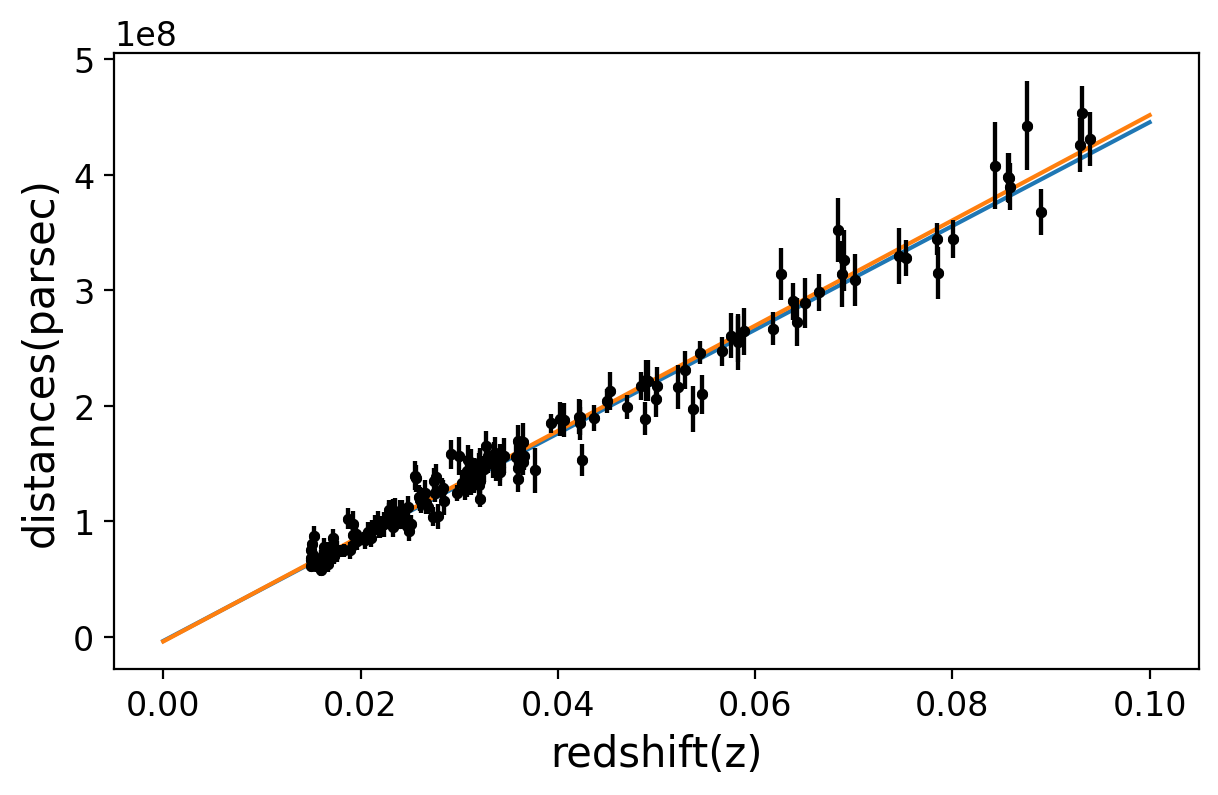

In [10]:
#>>>RUN: L4.4-runcell01

weights=[]
for err in distance_err:
    weights.append(1./err**2)
weights = np.array(weights)
#note we can write this as weights=1./err**2 directly in numpy

#Now let's do it with weights
def variance_w(isamples,iweights):
    mean=np.average(isamples,weights=iweights)
    sumw=np.sum(iweights)
    tot=0
    for i0 in range(len(isamples)):
        tot+=iweights[i0]*(isamples[i0]-mean)**2
    return tot/sumw

def covariance_w(ixs,iys,iweights):
    meanx=np.average(ixs,weights=iweights)
    meany=np.average(iys,weights=iweights)
    sumw=np.sum(iweights)
    tot=0
    for i0 in range(len(ixs)):
        tot+=iweights[i0]*(ixs[i0]-meanx)*(iys[i0]-meany)
    return tot/sumw

def regress_w(redshift,weights,distance):
    varw=variance_w(redshift,weights)
    covw=covariance_w(redshift,distance,weights)
    Aw=covw/varw
    bw=np.average(distance,weights=weights)-Aw*np.average(redshift,weights=weights)
    return Aw,bw

Aw,bw=regress_w(redshift,weights,distance)
plotAll(redshift,distance,distance_err,Aw,bw)
plotAll(redshift,distance,distance_err,A,b)
plt.show()

*Brief aside on general form*:

One last quick technical point is that people often write the linear regression in terms of a matrix over a vector $\vec{x}$ where each element $x_{i}$ in the vector is one of our measurements. The linear equation is then written as 

$$
\begin{eqnarray} 
  \vec{\hat{y}} & = & A\vec{x}+b \\
  \vec{\hat{y}} & = & \beta\vec{x^{\prime}}\\
\end{eqnarray}
$$

where $\vec{x^\prime} = (\vec{x},1)$ The resulting solution for best fit is written as

$$
\begin{eqnarray} 
  \hat{\beta} & = & \frac{1}{N^{2}}(\vec{x}^{T}\vec{x})^{-1}\vec{x}^{T}\vec{y}
\end{eqnarray} 
$$

This is often how it is written in more advanced classes. In reality, this answer is no different than what we showed above. We haven't included weights here, but they can be added. 

<a name='exercises_4_4'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_4) | [Next Section](#section_4_5) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-4.4.1 Effects of Changing Uncertainty I</span>

Let's imagine, for no particular reason, that our uncertainty on any given observation is multiplied by a factor of the redshift. That is, we define a new $\sigma_{i}^{new} = z \sigma_{i}^{old}$. How would the Hubble constant found by fitting the data with these modified uncertainties change, compared to the case when $\sigma_{i}^{old}$ was used? Choose from the following options:

- The fitted value of the Hubble constant would increase
- The fitted value of the Hubble constant would decrease
- The fitted value of the Hubble constant would stay the same

You can modify the starting code below to find the answer.

Hubbles Constant: 67.18169915816088 intercept -2955631.4860942513


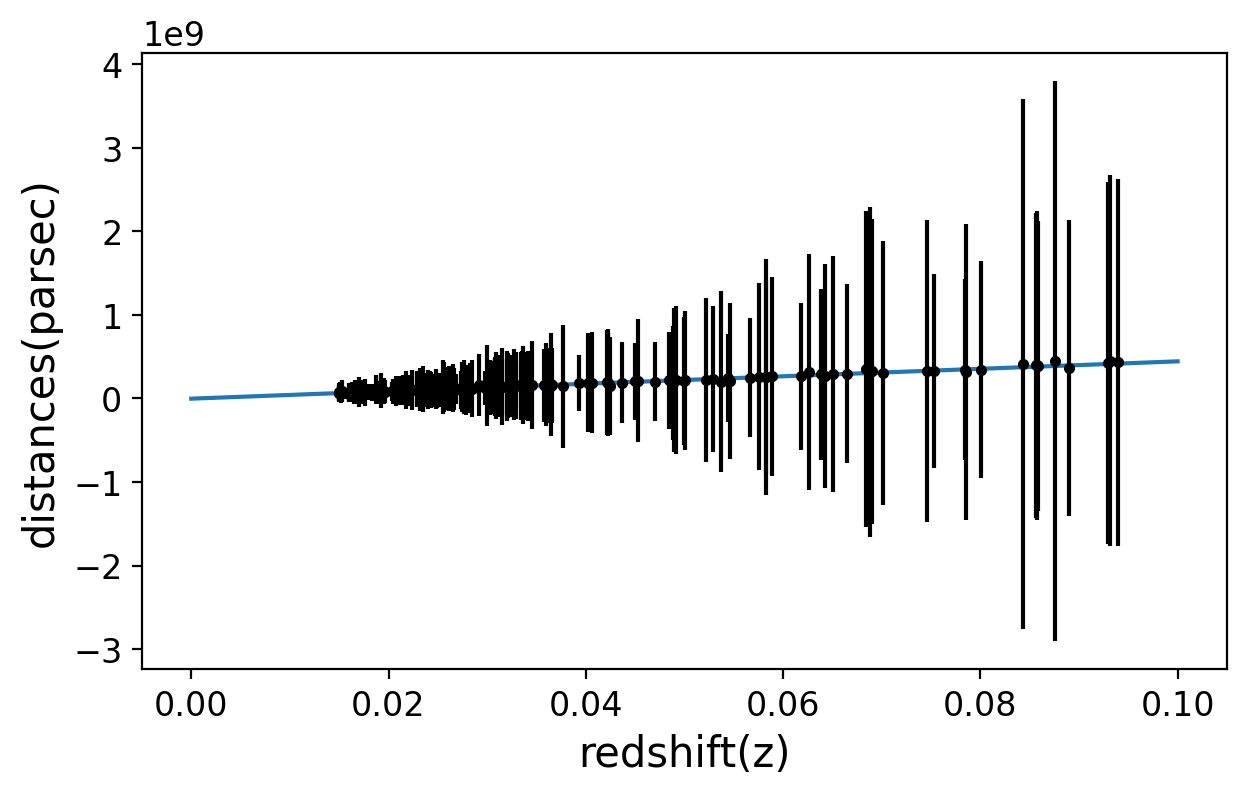

In [13]:
#>>>EXERCISE
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

#The code below scales the uncertainties being used in our weighted regression. 

import numpy as np

redshift,distance,distance_err = load(label,0.1)

# scale the errors by the redshift
new_errors = 1000*redshift*distance_err

# translate these scaled uncertainties into new weights for regression (1/sigma^2 for each)
weights = 1 / (new_errors * new_errors)

Aw,bw=regress_w(redshift,weights,distance)
plotAll(redshift,distance,new_errors,Aw,bw)

In [ ]:
#>>>SOLUTION

#The code below scales the uncertainties being used in our weighted regression. 
#We find an increase in the value of Hubble's constant fit from this data.

import numpy as np

redshift,distance,distance_err = load(label,0.1)

# scale the errors by the redshift
new_errors = redshift * distance_err

# translate these scaled uncertainties into new weights for regression (1/sigma^2 for each)
weights = 1 / (new_errors * new_errors)

Aw,bw=regress_w(redshift,weights,distance)
plotAll(redshift,distance,new_errors,Aw,bw)

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
We find an increase in the value of Hubble's constant from this modified fit to the data.
</pre>
        

</div>


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-4.4.2 Effects of Changing Uncertainty II</span>

What happens if I made a mistake and all of the errors are 100 times larger than what I thought, such that $\sigma_{i}^{new} = 100 \sigma_{i}^{old}$? How would the Hubble constant found by fitting the data with these modified uncertainties change, compared to the case when $\sigma_{i}^{old}$ was used?

Again, choose from the following options:

- The fitted value of the Hubble constant would increase
- The fitted value of the Hubble constant would decrease
- The fitted value of the Hubble constant would stay the same

You can modify the starting code below to find the answer.

In [ ]:
#>>>EXERCISE
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

import numpy as np

redshift,distance,distance_err = load(label,0.1)

# scale the errors by the redshift
new_errors = #YOUR CODE HERE

# translate these scaled uncertainties into new weights for regression (1/sigma^2 for each)
weights = 1 / (new_errors * new_errors)

Aw,bw=regress_w(redshift,weights,distance)
plotAll(redshift,distance,new_errors,Aw,bw)

In [ ]:
#>>>SOLUTION

import numpy as np

redshift,distance,distance_err = load(label,0.1)

# scale the errors by the redshift
new_errors =  distance_err*100

# translate these scaled uncertainties into new weights for regression (1/sigma^2 for each)
weights = 1 / (new_errors * new_errors)

Aw,bw=regress_w(redshift,weights,distance)
plotAll(redshift,distance,new_errors,Aw,bw)

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
Hubble\'s constant stays the same
</pre>
        
**EXPLANATION:**
    
We get the same result. However, the uncertainty on our result will change. We will discuss this in the next Lesson.
    
</div>


<a name='section_4_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L4.5 Minimization without the Math</h2>  

| [Top](#section_4_0) | [Previous Section](#section_4_4) | [Exercises](#exercises_4_5) | [Next Section](#section_4_6) |


<h3>Overview</h3>

Many models have more than two parameters. Let's do some generalizing. 

Consider an arbitrary function $f(x|\theta_{i})$ where $\theta_{i}$ denotes a given set of model parameters. For the linear regression, $\vec{\theta}=(A,b)$. The quantity we would want to minimize in the context of least-squares is

$$
\begin{equation}
Q=\sum_{i=1}^N \left(y-f(x\mid\theta_j)\right)^2,
\end{equation}
$$

which, in its most general form, gives us this set of partial derivatives:

$$
\begin{equation}
\frac{\partial Q}{\partial\theta_{i}} = \frac{\partial}{\partial \theta_{i}}\sum_{i=1}^{N}\left(y_{i}-f(x|\theta_{i}\right)^2=\sum_{i=1}^{N} 2 \left(y_{i}-f(x|\theta_{i}\right)\frac{\partial f(x|\theta_{i})}{\partial \theta_{i}}
\end{equation}
$$

Using this, we can, in principle, calculate the derivatives and set them to 0, and then solve for the parameters that minimize our loss function. However, in many cases that's much easier said than done.

Instead, we take a numerical approach, and fortunately there's plenty of packages to do so. Let's demonstrate by using the `scipy stats` toolkit to perform the linear regression. Note, this code comes more or less straight from examples in the `scipy` documentation.

In [14]:
#>>>RUN: L4.5-runcell01

from scipy import stats
from sklearn.linear_model import LinearRegression

#Now lets do the same thing with scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(redshift,distance)
print("UnWeighted Fit:","Hubbles Constant:",1e6*3e5/slope,"intercept",intercept)

#Now the weighted version; we use scikit-learn, a package dedicated to fitting
model = LinearRegression()
redshifthack=np.reshape(redshift,(len(redshift),1))#line to get the fit code to work
model.fit(redshifthack,distance,weights)
slope=model.coef_
const=model.intercept_
print("Weighted Fit:","Hubbles Constant:",1e6*3e5/slope,"intercept",const)

UnWeighted Fit: Hubbles Constant: 65.87381819553848 intercept -3931446.778206587
Weighted Fit: Hubbles Constant: [67.18169916] intercept -2955631.4860943705


What exactly is going on under the hood? You could, of course, look at the `scipy` documentation and from there find the relevant source code. But, in short, there is an optimizer that uses numerical methods to evolve the values of the slope ($A$) and intercept ($b$) until a minimum of the objective is reached.

In fact, we can access this optimizer directly! Let's see what it does.

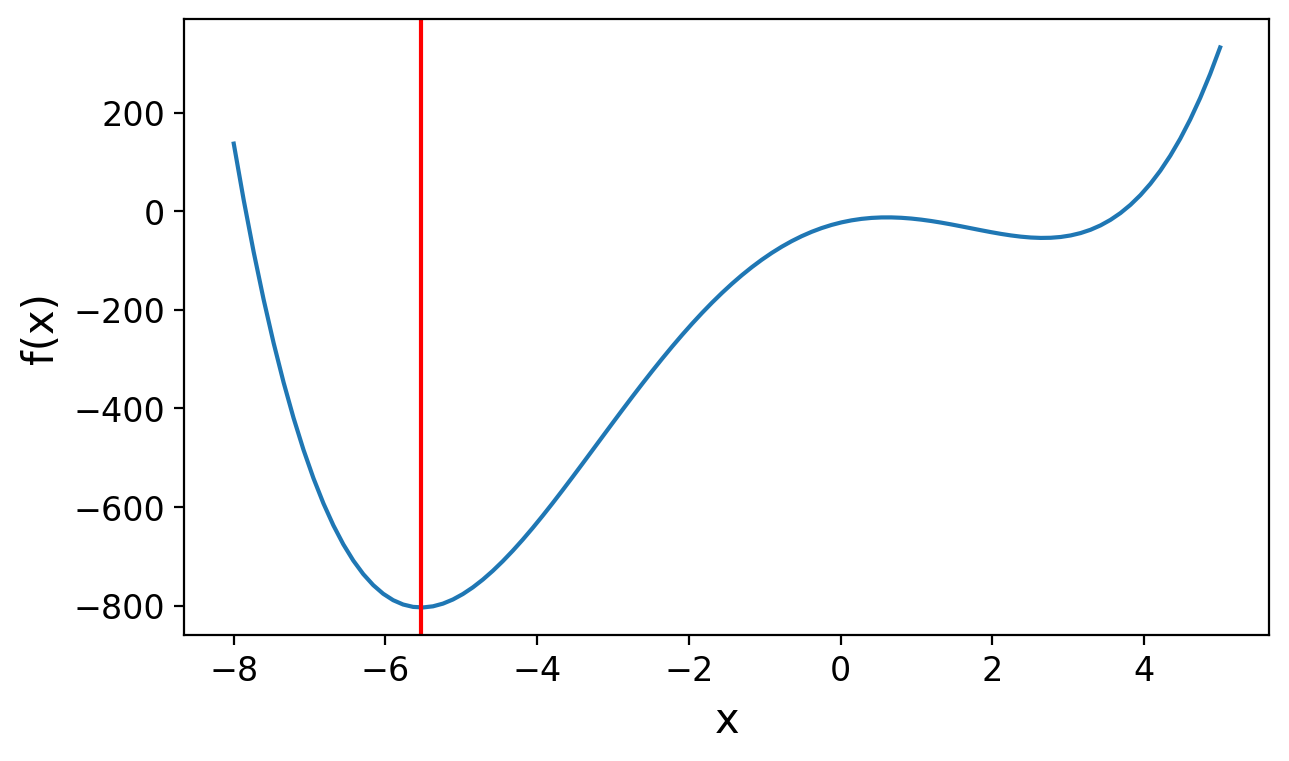

In [17]:
#>>>RUN: L4.5-runcell02

#scipy provides the general tool that optimizes
from scipy import optimize as opt

#First an example minimizing a simple polynomial
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

sol=opt.minimize_scalar(f, method='Brent')
x = np.linspace(-8, 5, 100)

plt.xlabel('x', fontsize=15) #Label x
plt.ylabel('f(x)', fontsize=15)#Label y
plt.plot(x, f(x));
plt.axvline(sol.x, c='red')
plt.show()

The optimizer successfully found a minimum! Before we discuss how it works, let's go ahead and see how we can use scipy's optimizers to perform a fit. We'll also see how uncertainties fit into this.

In [17]:
#>>>RUN: L4.5-runcell03

# scipy offers a tool for fitting a generic curve to data.
# It's using the same sort of optimizer, to optimize its choice of error metric
from scipy.optimize import curve_fit 

# We define a curve functional form
def f(x,a,b):
    return a*x+b

popt, pcov = curve_fit(f, redshift,distance) # returns optimal values of a, b in popt
perr = np.sqrt(np.diag(pcov))
print("Unweighted Hubbles Constant:",1e6*3e5/popt[0],"+/-",(1e6*3e5/popt[0]/popt[0])*perr[0],"intercept",popt[1],"+/-",perr[1])

#Now let's do it weighted by uncertainties, by passing them in the "sigma" optional argument
popt, pcov = curve_fit(f, redshift,distance,sigma=distance_err)
perr = np.sqrt(np.diag(pcov))
print("Weighted Hubbles Constant:",1e6*3e5/popt[0],"+/-",(1e6*3e5/popt[0]/popt[0])*perr[0],"intercept",popt[1],"+/-",perr[1])

Unweighted Hubbles Constant: 65.87381783782733 +/- 0.7224431434183999 intercept -3931447.9363341173 +/- 2047227.4423644699
Weighted Hubbles Constant: 66.84173200500216 +/- 0.8288759303762454 intercept -3501821.4128609835 +/- 1587584.3707810403


<a name='exercises_4_5'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_5) | [Next Section](#section_4_6) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-4.5.1 Finding the Minimum of a Potential</span>

One of the most important distributions used in high energy physics is the Mexcian Hat Potential distribution. A generic form is given by: 

$$
\begin{eqnarray} 
  V(x,y) & = & (x^2+y^2)^2-A(x^2+y^2)
\end{eqnarray}
$$

Here, let's consider a 1D version where we fix $y$ and $A$, so we can write this as: 

$$
\begin{equation}
f(x) = (x-2)^{2}(x+2)^2-24x^2
\end{equation}
$$

**Complete the code below to find ONE minimum of this new potential, using bounded minimization. What is the value of the minimum that you obtained? Enter your answer as a number with precision 1e-3.**

*Note, in the next video we will look at a potential with slightly different values, and discuss some aspects of the minimization.*

*Check out the `scipy.optimize.minimize` documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html*

*Also, for your interest, similarly shaped potentials include the Ricker potential, which you can read more about here: https://en.wikipedia.org/wiki/Ricker_wavelet*

min value over the array x: -3.999998955611505


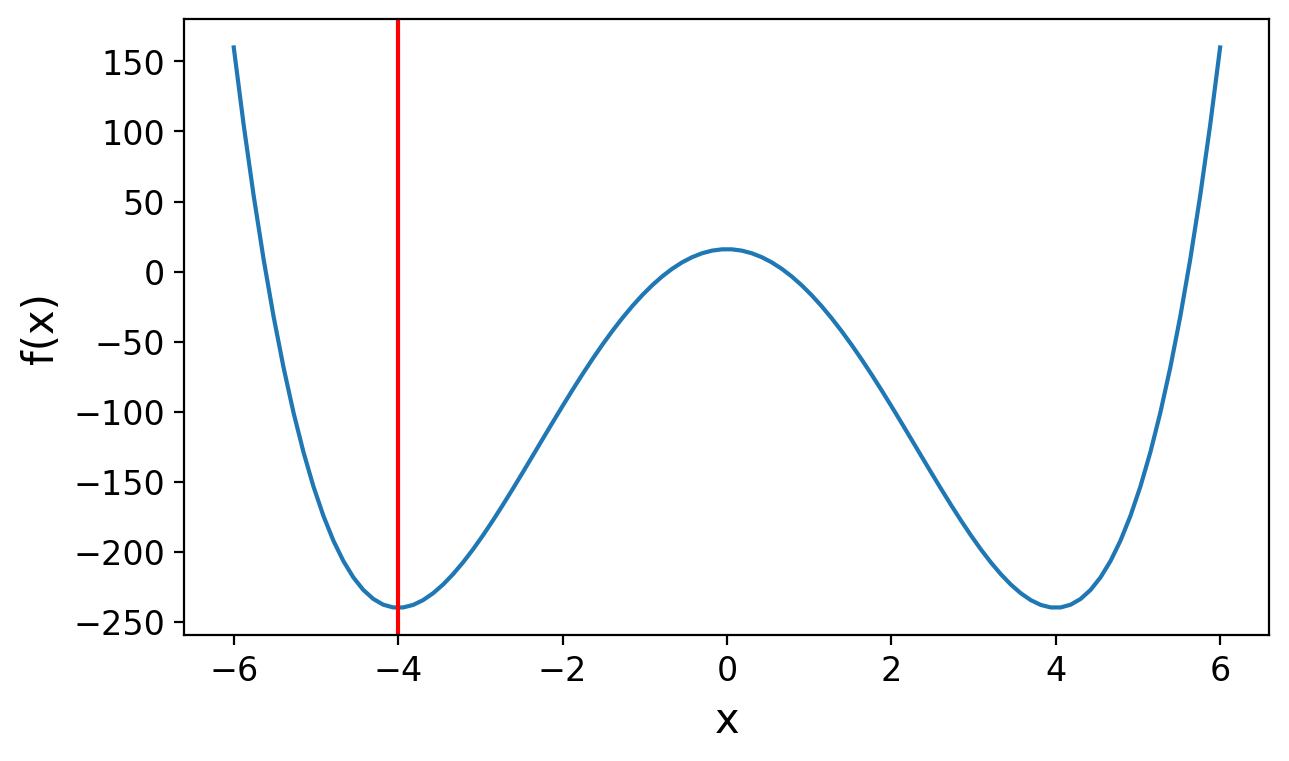

In [18]:
#>>>EXERCISE
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt

def f(x):
    return (x-2)**2*(x+2)**2-24*x**2#YOUR CODE HERE

sol=opt.minimize_scalar(f, bounds=(-6,6), method='bounded')
x = np.linspace(-6, 6, 100)

print('min value over the array x:',sol.x)

plt.xlabel('x', fontsize=15) #Label x
plt.ylabel('f(x)', fontsize=15)#Label y
plt.plot(x, f(x));
plt.axvline(sol.x, c='red')
plt.show()


min value over the array x: -3.999998955611505


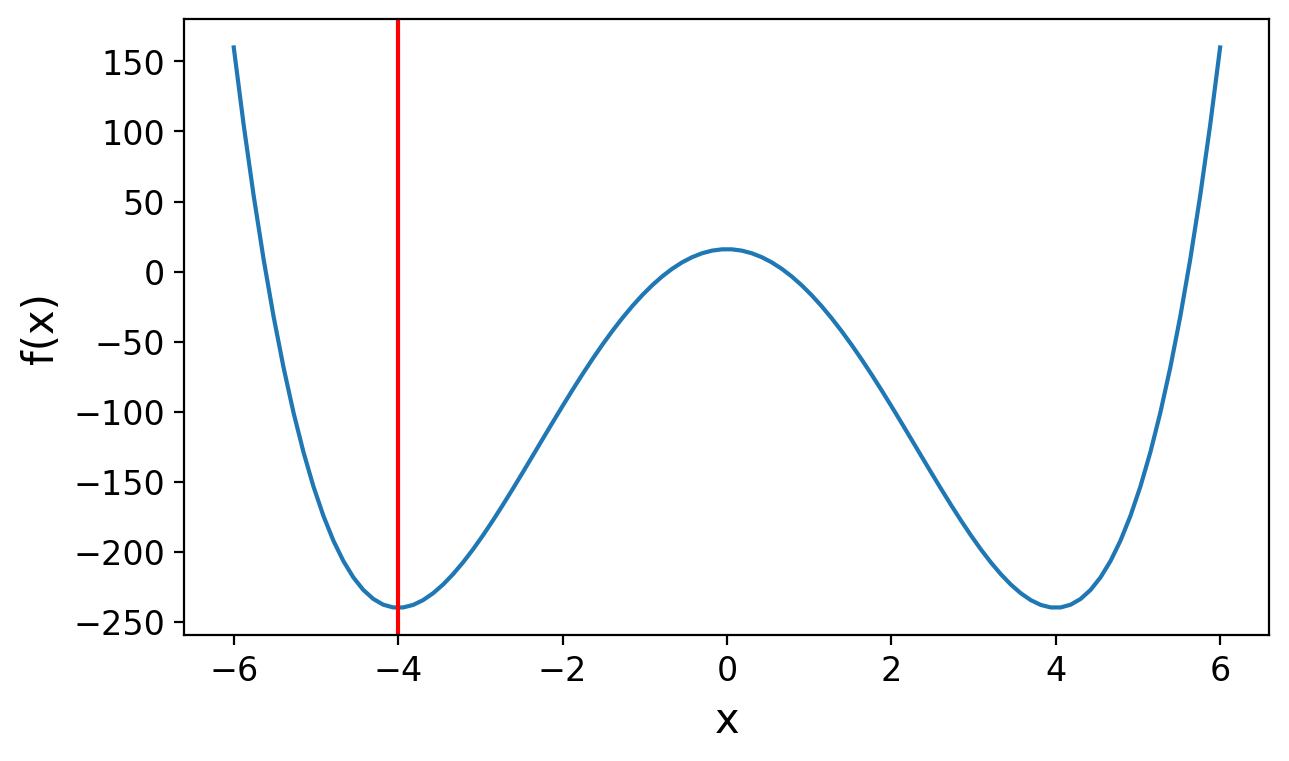

In [19]:
#>>>SOLUTION
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt

def f(x):
    return ((x-2)**2)*((x+2)**2)-24*x**2

sol=opt.minimize_scalar(f, bounds=(-6,6), method='bounded')
x = np.linspace(-6, 6, 100)

print('min value over the array x:',sol.x)

plt.xlabel('x', fontsize=15) #Label x
plt.ylabel('f(x)', fontsize=15)#Label y
plt.plot(x, f(x));
plt.axvline(sol.x, c='red')
plt.show()

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
4
</pre>
        
**EXPLANATION:**
    
Use scipy.optimize to skip the math and locate the function minimum. However, we know the shape of a Mexican hat potential has a minimum at several locations. Thus, by adjusting our bounds, we can locate two different minimums using scipy.optimize. If we adjust our bounds to be closer to one or the other we find the minimum that is closer.
     
</div>


>#### Follow-up 4.5.1a (ungraded)
>
>What makes this minimum particularly interesting? 

>#### Follow-up 4.5.1b (ungraded)
>
>Change the bounds of the minimizer. Does this lead to different results?

>#### Follow-up 4.5.1c (ungraded)
>
>Try changing the function to create an asymmetric potential (for example, add $x$). Does the minimizer find the global mimimum, or is it stuck in the local minimum? Do different methods (for instance `brent`) do a better or worse job?

<a name='section_4_6'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L4.6 Gradient Descent</h2>  

| [Top](#section_4_0) | [Previous Section](#section_4_5) | [Exercises](#exercises_4_6) | [Next Section](#section_4_7) |


<h3>Slides</h3>

Run the code below to view the slides for this section, which are discussed in the related video. You can also open the slides in a separate window <a href="https://mitx-8s50.github.io/slides/L04/slides_L04_06.html" target="_blank">HERE</a>.

In [ ]:
#>>>RUN: L4.6-slides

from IPython.display import IFrame
IFrame(src='https://mitx-8s50.github.io/slides/L04/slides_L04_06.html', width=975, height=550)

<h3>Slides</h3>

View the slides for this section below, which are discussed in the related video. You can also open the slides in a separate window <a href="https://mitx-8s50.github.io/slides/L04/slides_L04_06.html" target="_blank">HERE</a>.

<p align="center">
<iframe src="https://mitx-8s50.github.io/slides/L04/slides_L04_06.html" width="900", height="550" frameBorder="0"/>
</p>

<h3>Overview</h3>

Another way to think about minimization: Imagine a ball sliding around on our function, under gravity. The value of our function, then, is like the value of the gravitational potential, which we'll call $U$.

How does this ball move? Recall that for a potential given by $U$ the corresponding force an object experiences is

$$F=-\nabla U$$ 

where $\nabla$ is the gradient (or in 1D, derivative). Since $F=ma$, we know

$$\vec{a}=-\frac{1}{m}\nabla U$$

which, integrating, gives the velocity:

$$\vec{v}=\int \vec{a} dt =-\int \frac{1}{m}\nabla U dt$$,

and then position:

$$\vec{x}=\int \vec{v} dt =\int \int \vec{a} dt dt =-\int \int \frac{1}{m}\nabla U dt dt$$

up to initial conditions.

With this as inspiration, if we're trying to minimize some function $U$, we can start at a point and then iterate in discrete timesteps $\delta t$, approximating the motion of such a ball along that function:

$$
\begin{eqnarray}
\vec{v} = \vec{v_0} - \delta t \nabla U \\
\vec{x} = \vec{x_0} + \delta t \vec{v} - (\delta t)^2\nabla U
\end{eqnarray}
$$

Let's code this up by hand. The resulting algorithm is a type of **gradient descent**.

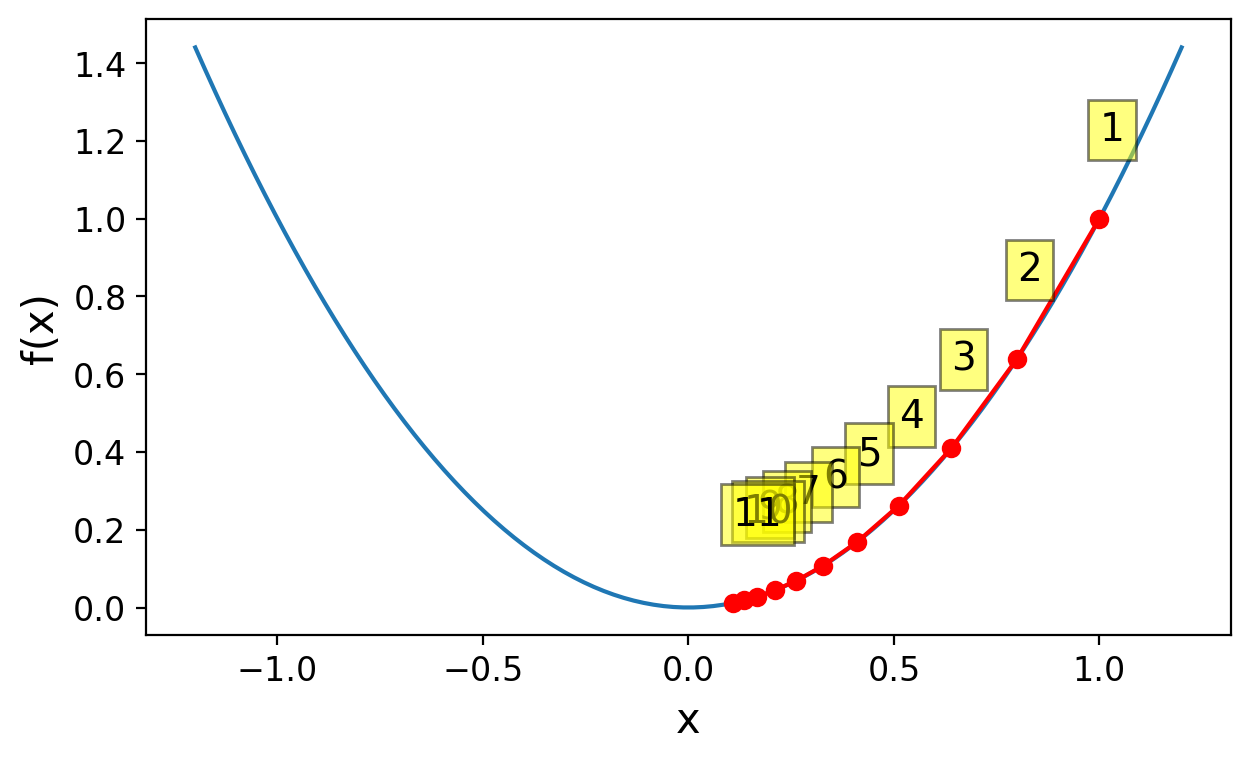

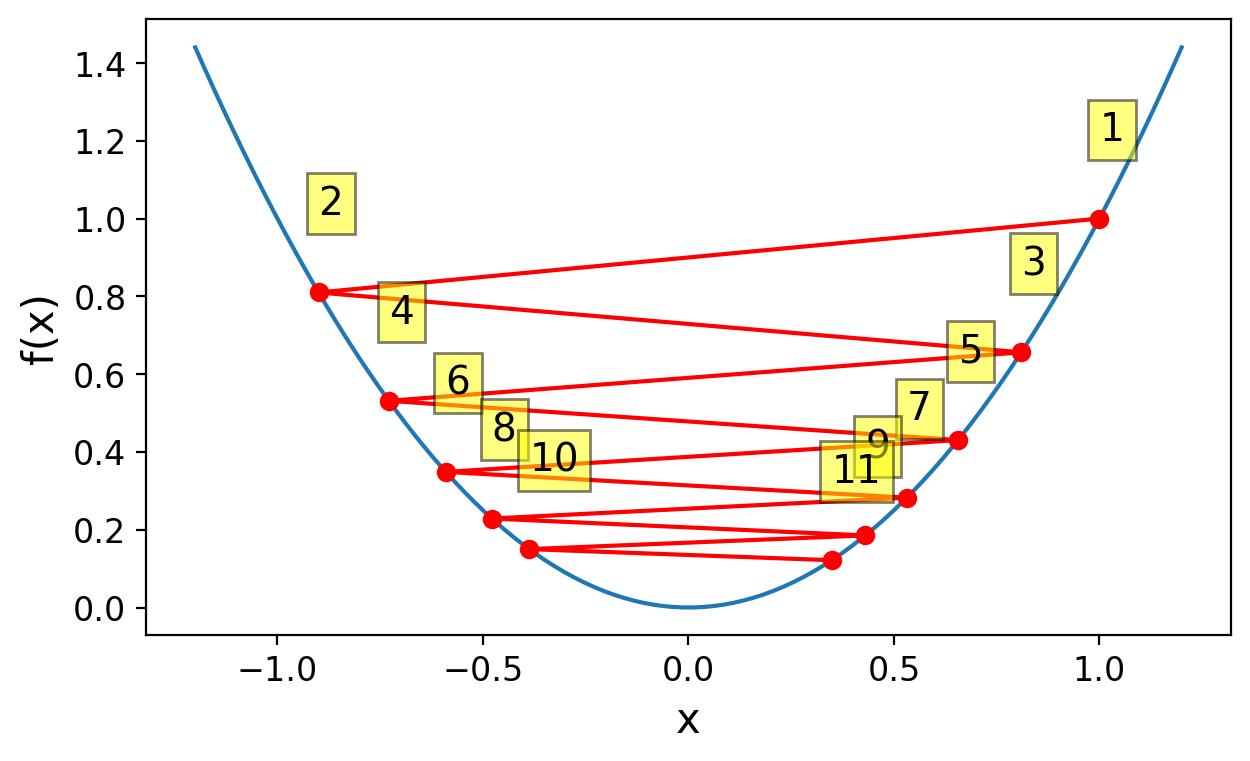

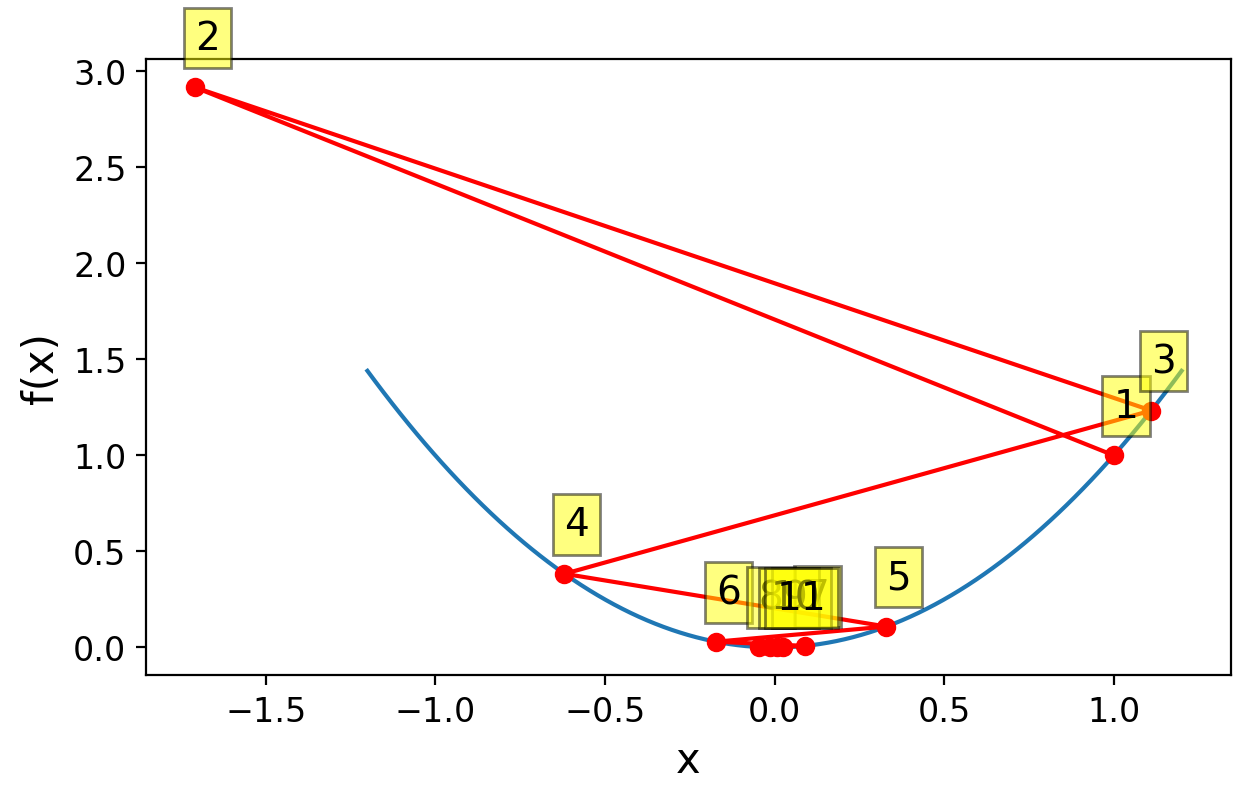

In [19]:
#>>>RUN: L4.6-runcell01

#Let's find the minimum of x^2
def f(x):
    return x**2
# We need to define the gradient of f
def grad(x):
    return 2*x

#Simple gradient descent (this one is not physics-based, but rather just steps along the gradient)
#Starting on x, move in the direction of negative gradient, scaled by alpha (delta t from earlier)
def gd(x, grad, alpha, max_iter=10):
    xs = np.zeros(1 + max_iter)
    xs[0] = x #start at x
    for i in range(max_iter):
        x = x - alpha * grad(x)
        xs[i+1] = x
    return xs

#Physics based gradient descent, which comes from our equations above
#Now will update both position and velocity in timesteps alpha
def gd_momentum_nd(x, grad, alpha, max_iter=10):
    xs = np.zeros(1 + max_iter)
    xs[0] = x
    v = 0
    for i in range(max_iter):
        v = v - alpha*grad(x)
        x = x + alpha * v  - 0.5 * alpha * alpha*grad(x)
        xs[i+1] = x
    return xs

def plotGDAlgo(iGDAlgo,alpha=0.1,beta=None,x0=1):
    if beta is not None:
        xs = iGDAlgo(x0, grad, alpha, beta)
    else:
        xs = iGDAlgo(x0, grad, alpha)
    xp = np.linspace(-1.2, 1.2, 100)

    #Now just plotting code
    plt.xlabel('x', fontsize=15) #Label x
    plt.ylabel('f(x)', fontsize=15)#Label y
    plt.plot(xp, f(xp)) #function
    plt.plot(xs, f(xs), 'o-', c='red') #varied function
    for i, (x, y) in enumerate(zip(xs, f(xs)), 1):
        plt.text(x, y+0.2, i,bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14)
    plt.show()    

plotGDAlgo(gd)
plotGDAlgo(gd,0.95) #large timestep alpha
plotGDAlgo(gd_momentum_nd,0.95) #Large timestep, with momentum

The simple, non-physics based gradient descent with small timestep (first plot) works. The one with large timestep (second plot) works as well, though it overshoots. Our physics-based one (third plot) jumps around.

Actually, if our discrete time stepping accurately modeled the equations of motion of a ball on the potential energy surface, the physics-based method would never converge, because energy is conserved (as we've defined it, the system is frictionless)! Rather, the ball would roll back and forth forever. In this case we get lucky, and errors in our discrete implementation lead us to the minimum. But this is not guaranteed!

We need to add a friction term, which we'll parameterize by a number damp$<1$. In this case, we will define it as 

$$
\begin{equation}
 \rm{damp} = \frac{1}{1+\beta^{\rm{iter}+1}}
\end{equation}
$$

for a new parameter $\beta<1$  and $iter$ the iteration step number. 

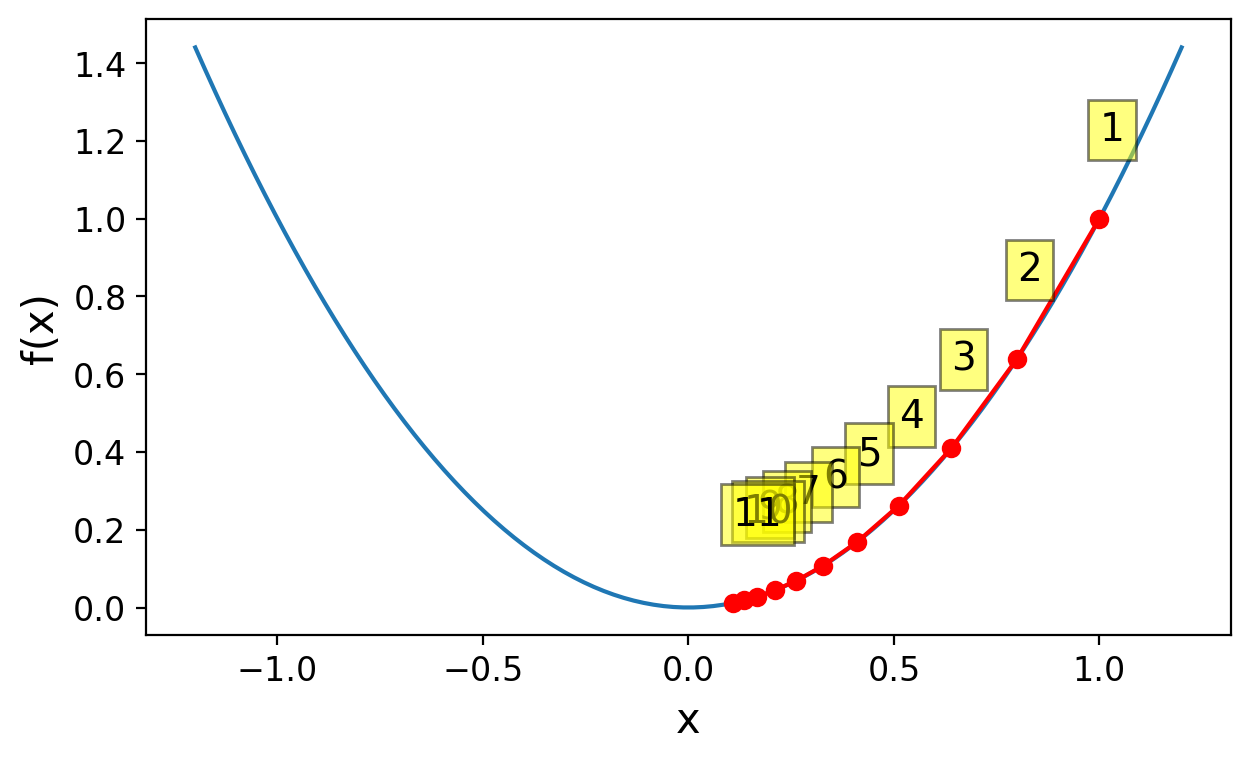

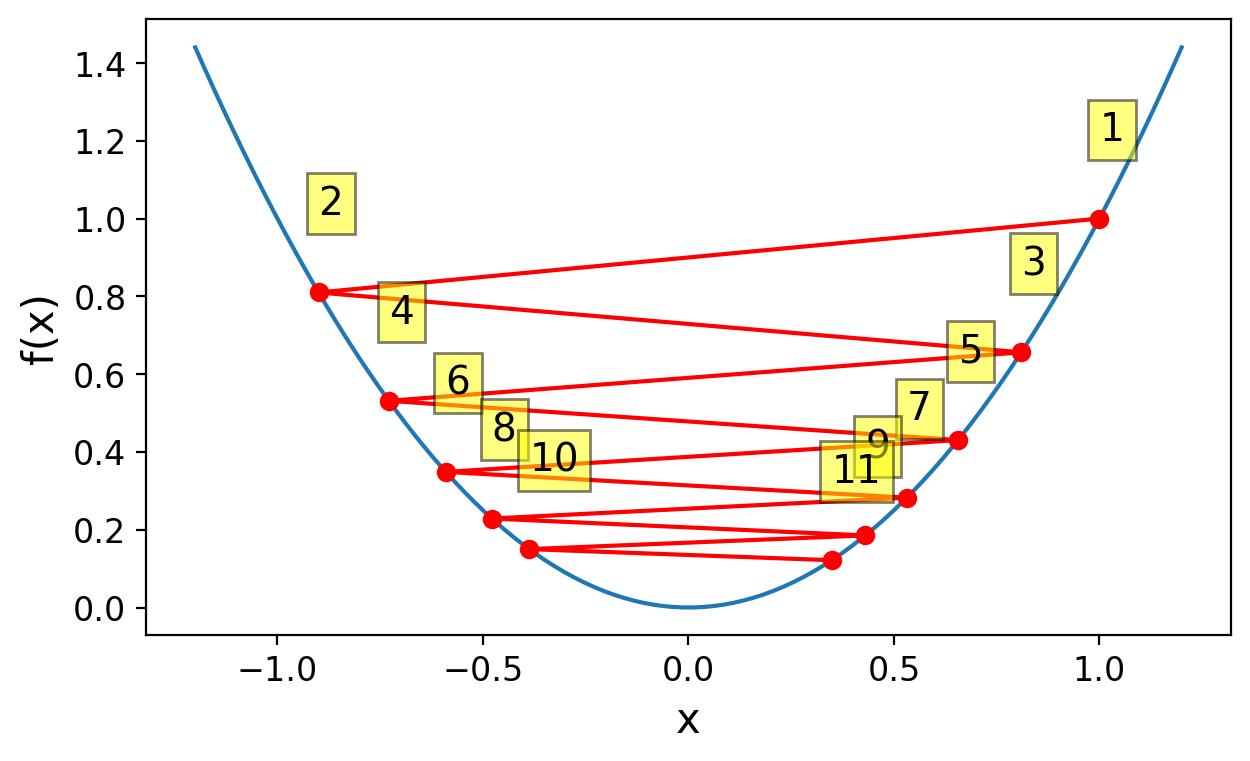

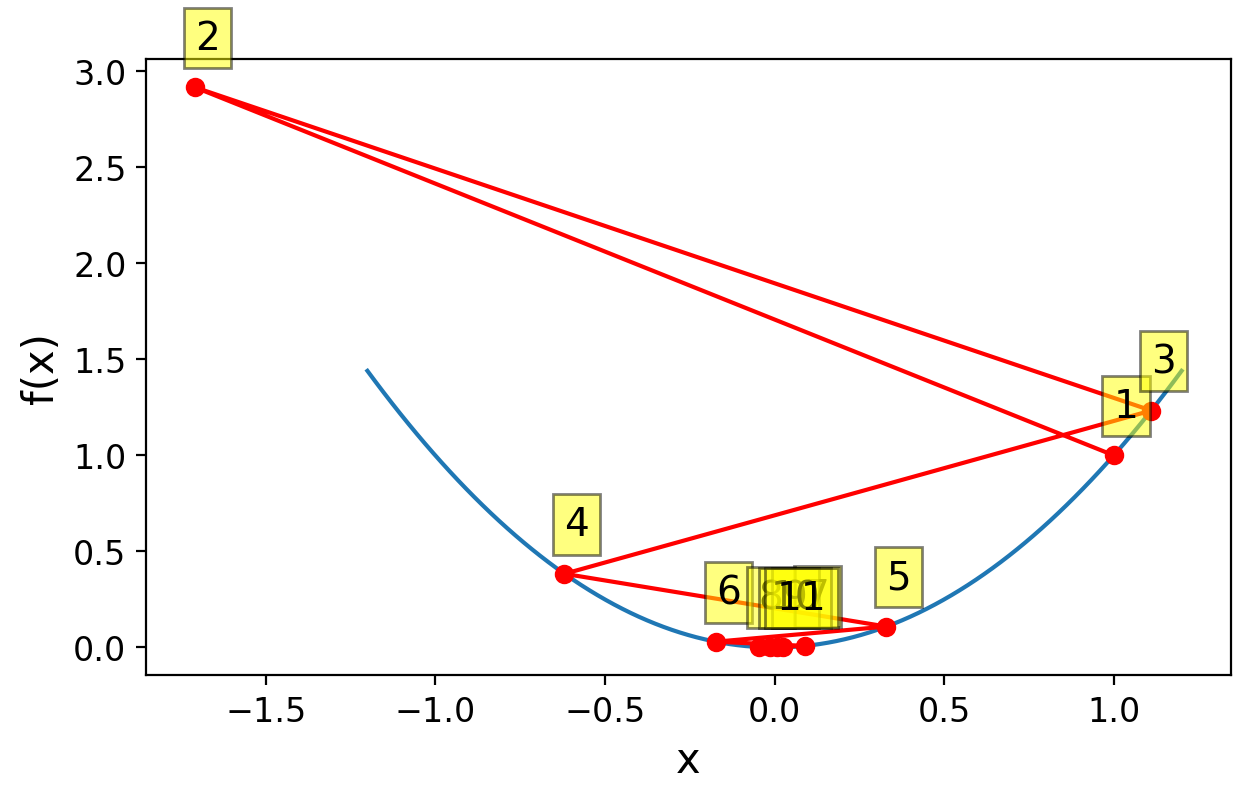

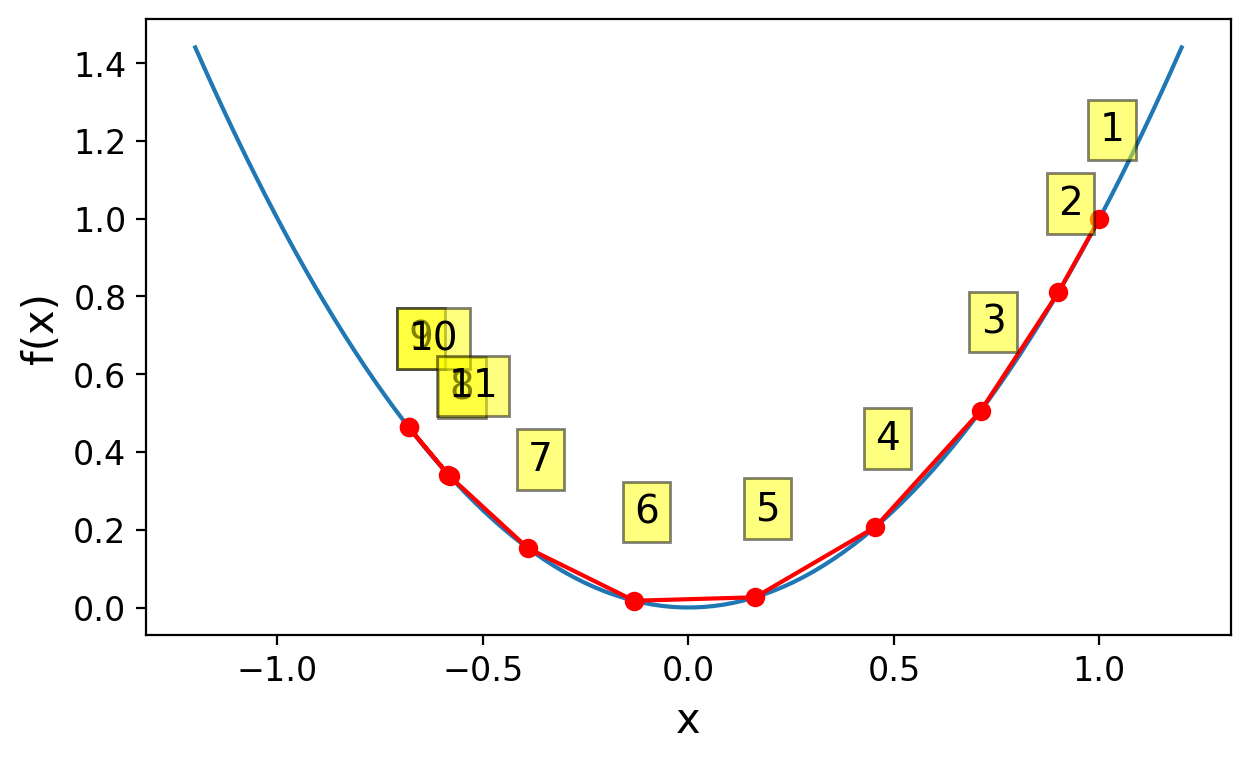

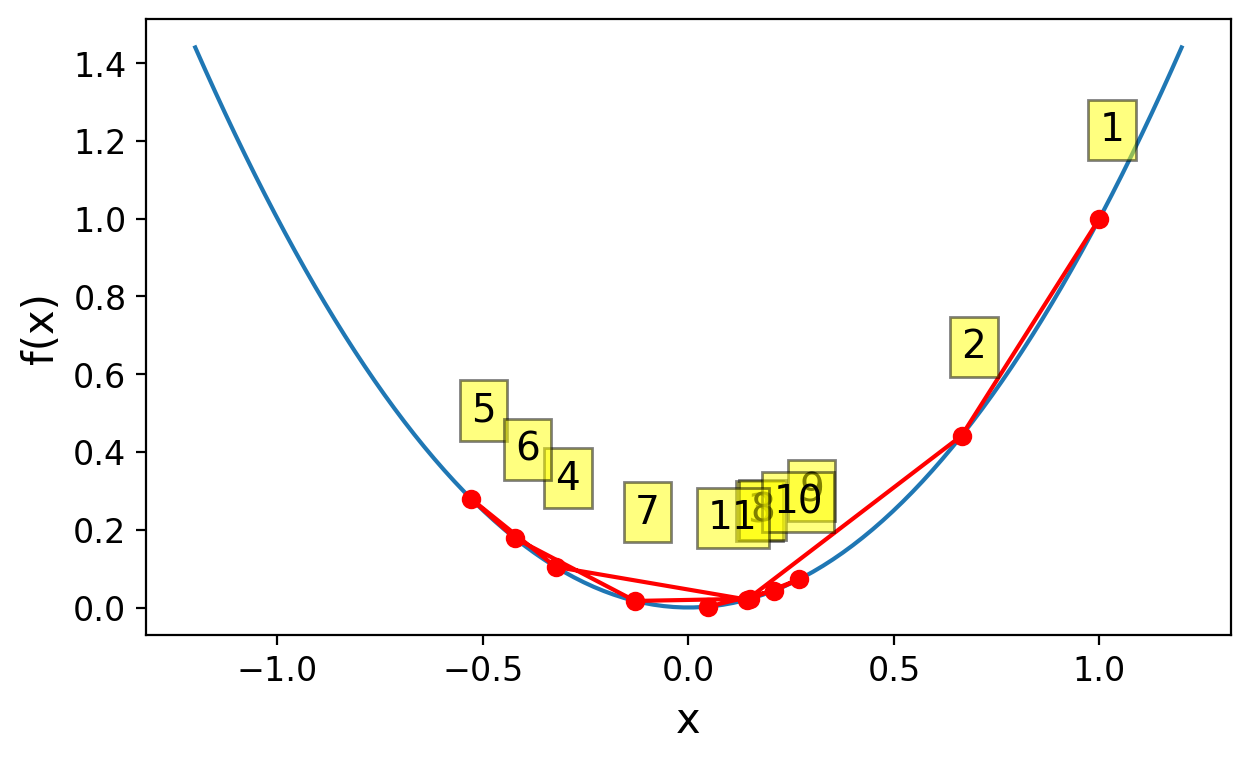

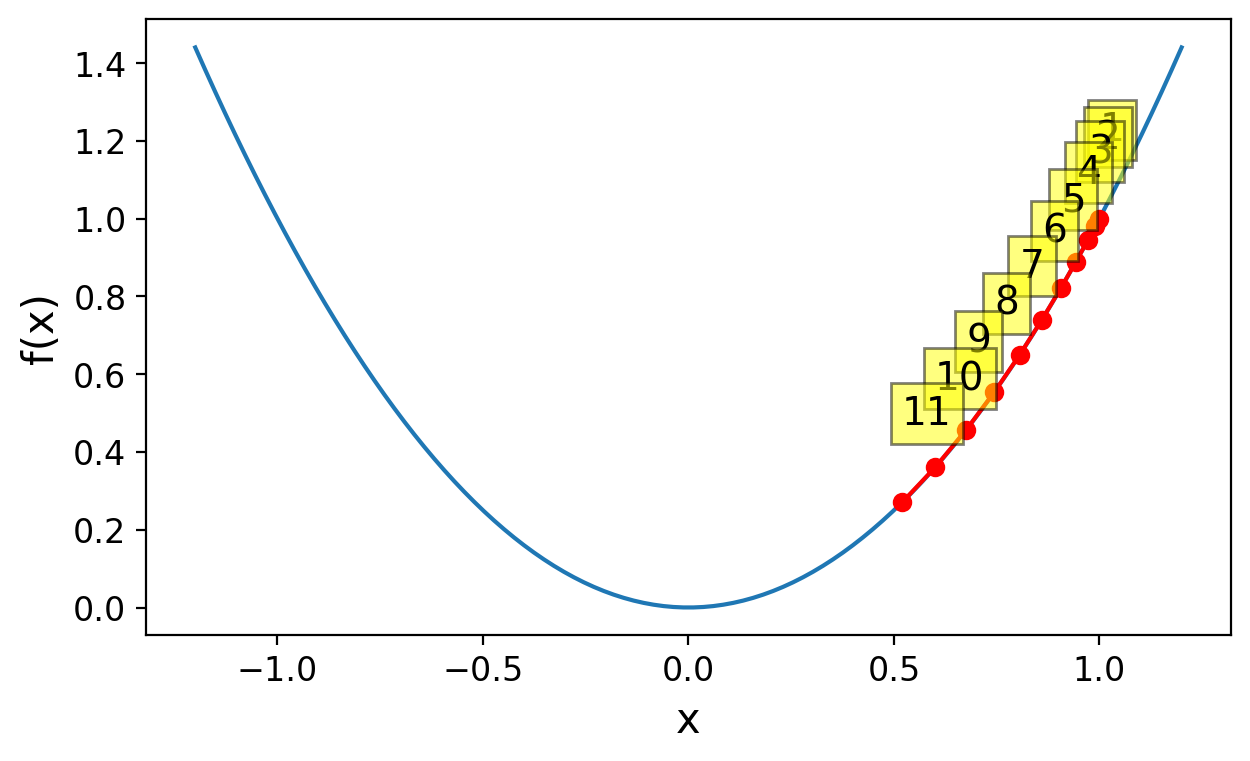

In [20]:
#>>>RUN: L4.6-runcell02

#Now will update both momentum and velocity in timesteps alpha but with a dilution factor of beta
def gd_momentum(x, grad, alpha, beta=0.9, max_iter=10):
    xs = np.zeros(1 + max_iter)
    xs[0] = x
    v = 0
    for i in range(max_iter):
        v = beta*v + (1-beta)*grad(x) # beta effectively scales how much the velocity is affected by the local gradient
        vc = v/(1+beta**(i+1)) # and also controls the damping of the velocity
        x = x - alpha * vc
        xs[i+1] = x
    return xs

plotGDAlgo(gd)
plotGDAlgo(gd,0.95) #large timestep alpha
plotGDAlgo(gd_momentum_nd,0.95) #Large timestep
plotGDAlgo(gd_momentum,0.95,beta=0.9) #Large timestep
plotGDAlgo(gd_momentum,0.95,beta=0.7) #Large timestep
plotGDAlgo(gd_momentum,0.95,beta=0.99) #Large timestep

All of these guys approach the minimum and you can be quite flexible with the behavior. We can, in fact, use any minimization function we want in `scipy.optimize`. It will do the iterative stepping for us. Let's write our own minimizer and throw it in. We can do it for our previous quartic equation.

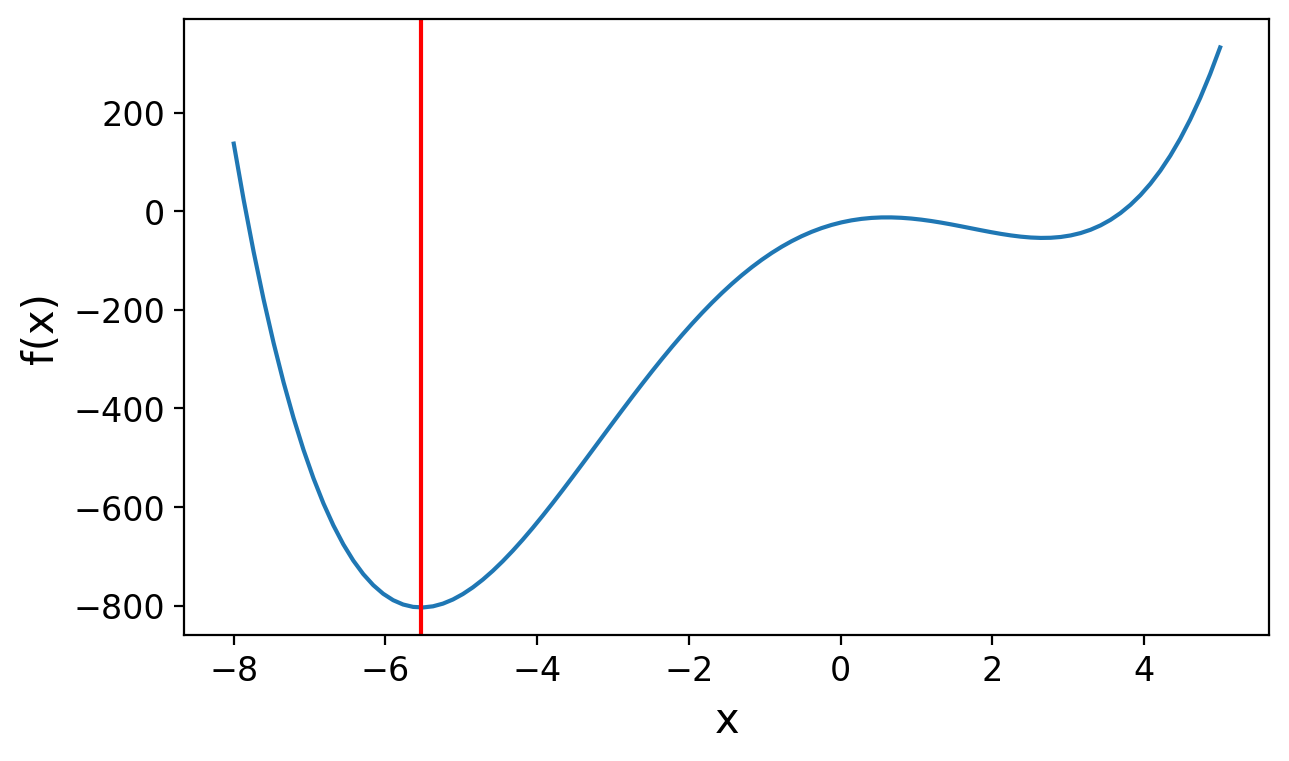

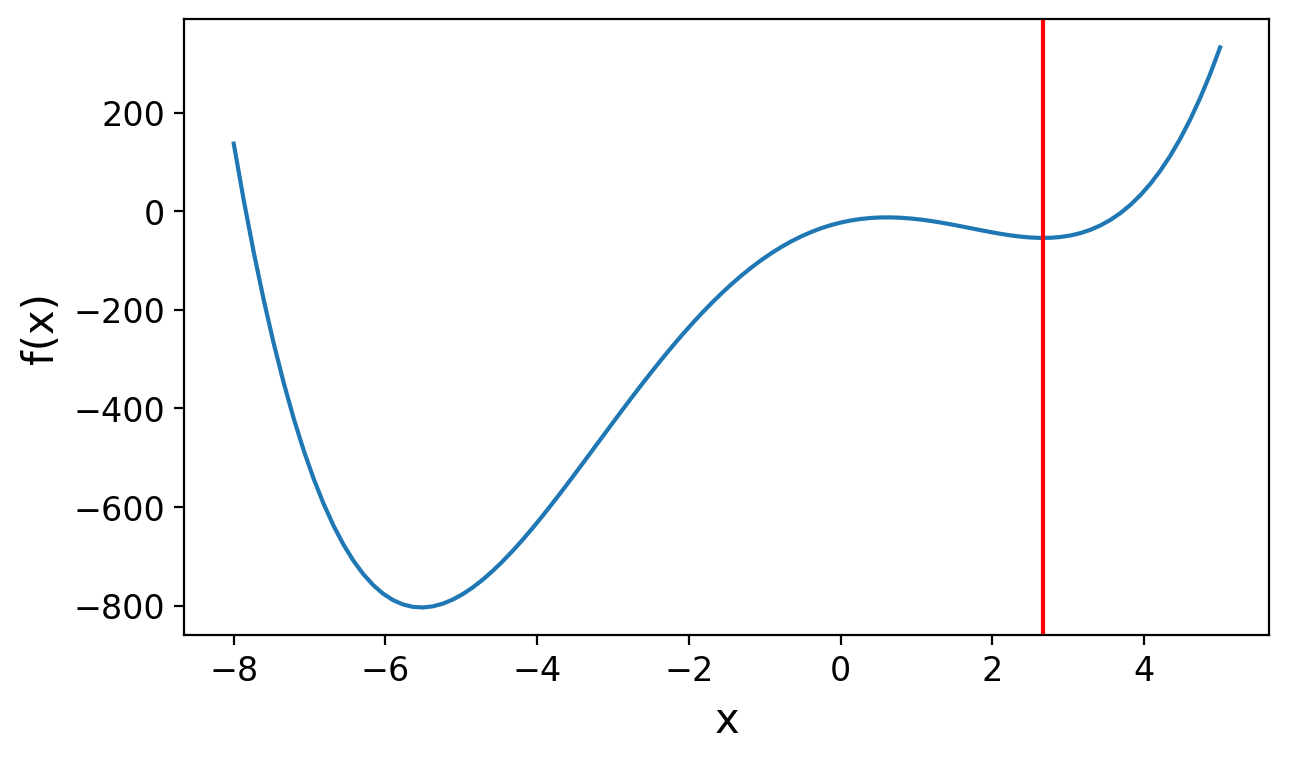

In [21]:
#>>>RUN: L4.6-runcell03

#Now let's do this with a general tool that optimizes
import scipy.linalg as la
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

def fprime(x):
    return 4*x**3 + 9*(x-2)**2 - 30*(x)

#Where is our minimizer
def custmin(fun, x0, args=(), maxfev=None, alpha=0.0002,
        maxiter=100000, tol=1e-10, callback=None, **options):
    """Implements simple gradient descent for the function above."""
    bestx = x0
    bestf = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        niter += 1
        # the next 2 lines are gradient descent
        step = alpha * fprime(bestx)
        bestx = bestx - step
        
        bestf = fun(bestx)
        funcalls += 1

        if la.norm(step) < tol:
            improved = False
        if callback is not None:
            callback(bestx)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break

    return opt.OptimizeResult(fun=bestf, x=bestx, nit=niter,nfev=funcalls, success=(niter > 1))

def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)

x0=-7
x0 = np.array([x0])
ps = [x0]
sol=opt.minimize(f, x0, method=custmin, callback=reporter)
x = np.linspace(-8, 5, 100)
plt.xlabel('x', fontsize=15) #Label x
plt.ylabel('f(x)', fontsize=15)#Label y
plt.plot(x, f(x));
plt.axvline(sol.x, c='red')
plt.show()

#Now let's trick it
x0=5
x0 = np.array([x0])
ps = [x0]
sol=opt.minimize(f, x0, method=custmin, callback=reporter)
x = np.linspace(-8, 5, 100)
plt.xlabel('x', fontsize=15) #Label x
plt.ylabel('f(x)', fontsize=15)#Label y
plt.plot(x, f(x));
plt.axvline(sol.x, c='red')
plt.show()

<a name='exercises_4_6'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_6) | [Next Section](#section_4_7) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-4.6.1</span>

Let's say you were stuck using the simple minimizer that we developed above. Let's also assume that the global mimimum is within some range that you know. What could you do to make sure your minimizer finds the global minimum, instead of getting stuck in a local minimum? Select all that apply:

- Use a larger number of iterations.
- Use a smaller number for the tolerance.
- Choose random starting points for the minimizer, and save the result that yields the lowest value.
- Restart your minimizer once it finds it's first minimum, and use a new starting point that is some pre-defined (perhaps random) distance away from the minimum that is found; do this several times and save the result that yields the lowest value.


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
Choose random starting points for the minimizer, and save the result that yields the lowest value.

Restart your minimizer once it finds it's first minimum, and use a new starting point that is some pre-defined (perhaps random) distance away from the minimum that is found; do this several times and save the result that yields the lowest value.
</pre>
        
**EXPLANATION:**
    
As long as the minimizer is finding a minimum before the max number of iterations are reached, increasing the number of iterations will not change anything.
    
Changing the tolerance will affect how quickly the minimizer finds a solution. In fact, using a very small number may require a higher setting for the maximum number of iterations. The tolerance may change the final result by a small amount, but it will not help the minimizer find another minimum.
    
The last two options essentially run the solver multiple times and take the best result. These are two ways to find other minima, but they make the solver rather inefficient.
    
</div>


>#### Follow-up 4.6.1a (ungraded)
>
>Try some of the strategies above. What works? What does not?

<a name='section_4_7'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L4.7 Fitting the Full Range of Hubble Data</h2>  

| [Top](#section_4_0) | [Previous Section](#section_4_6) | [Exercises](#exercises_4_7) | [Next Section](#section_4_8) |


<h3>Slides</h3>

Run the code below to view the slides for this section, which are discussed in the related video. You can also open the slides in a separate window <a href="https://mitx-8s50.github.io/slides/L04/slides_L04_07.html" target="_blank">HERE</a>.

In [ ]:
#>>>RUN: L4.7-slides

from IPython.display import IFrame
IFrame(src='https://mitx-8s50.github.io/slides/L04/slides_L04_07.html', width=975, height=550)

<h3>Slides</h3>

View the slides for this section below, which are discussed in the related video. You can also open the slides in a separate window <a href="https://mitx-8s50.github.io/slides/L04/slides_L04_07.html" target="_blank">HERE</a>.

<p align="center">
<iframe src="https://mitx-8s50.github.io/slides/L04/slides_L04_07.html" width="900", height="550" frameBorder="0"/>
</p>

<h3>Overview</h3>

Now, what if we want to minimize a function a fit function in two dimensions.  To do that, we are going to go back to our supernova data, and fit the line with a modified slope expansion given by:

$$ f(x) = \frac{x}{h_{0}}\left(1+\frac{1-q}{2}x\right) $$

Additionally, we have removed $b$, since this form is a closer approximation of the true form of the expansion of the universe, and in that instance $f(0)=0$

Recall that we needed to minimize: 

$$
\begin{equation}
 \frac{\partial Q}{\partial\theta_{i}} = \frac{\partial}{\partial \theta_{i}}\sum_{i=1}^{N}\left(y_{i}-f(x|\theta_{i}\right)^2=\sum_{i=1}^{N} 2 \left(y_{i}-f(x|\theta_{i})\right)\frac{\partial f(x|\theta_{i})}{\partial \theta_{i}}
\end{equation}
$$

, which means that we need to compute $\frac{\partial f}{\partial h_{0}}$ and $\frac{\partial f}{\partial q}$. We do it below in `fprime` and output a vector with two entries for $h_{0}$ and $q$. 

In [23]:
#>>>RUN: L4.7-runcell01

#Ok let's do a custom minimization of our fit function with gradient descent
#Note that since we are fitting two parameters we need to do this in 2D
redshift,distance,distance_err = load(label,10)
weights=np.array([])
for pVal in distance_err:
    weights = np.append(weights,1./pVal/pVal)

def f(x,h0,q):
    val=x*(1e6*3e5/h0)*(1 + ((1-q)*0.5)*x)
    return val

def fprime(x,h0,q):
    der=np.zeros(2)
    der[0]=-1*x*(1e6*3e5/h0/h0)*(1 + ((1-q)*0.5)*x)
    der[1]=x*(1e6*3e5/h0)*(-0.5*x)
    return der

def algof(inputs):
    d=0
    for i0 in range(len(redshift)):
        yhat=f(redshift[i0],inputs[0],inputs[1])
        pD=(distance[i0]-yhat)**2
        #pD=pD/dmean
        d+=pD*weights[i0]
    return d

def algofprime(inputs):
    d=np.zeros(2)
    for i0 in range(len(redshift)):
        yhat=f(redshift[i0],inputs[0],inputs[1])
        pD=2*(distance[i0]-yhat)
        yhatprime=fprime(redshift[i0],inputs[0],inputs[1])
        #print(yhatprime,pD,d)
        #pD=pD/dmean
        d=d+(yhatprime*pD)*weights[i0]
    return d

def custmin(fun, x0, args=(), maxfev=None, alpha=0.0001,maxiter=10000, tol=1e-10, callback=None, **options):
    """Implements simple gradient descent for the function above."""
    bestx = x0
    bestf = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        niter += 1
        if niter % 1000 == 0: 
            print(niter,bestx)
        # the next 2 lines are gradient descent
        step = alpha * algofprime(bestx)
        #print(bestx,step)
        bestx = bestx + step

        bestf = fun(bestx)
        funcalls += 1

        if la.norm(step) < tol:
            improved = False
        if callback is not None:
            callback(bestx)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break

    return opt.OptimizeResult(fun=bestf, x=bestx, nit=niter,nfev=funcalls, success=(niter > 1))

def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)

#tmp=algofprime([70,0.03])
x0 = np.array([40,0])
ps = [x0]
#sol0=opt.minimize(algof, x0, method=custmin, callback=reporter)
#print(sol0)
print()

sol1=opt.minimize(algof, x0)#, method=custmin, callback=reporter)
print(sol1)
    


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 562.8026474723313
        x: [ 6.918e+01 -1.348e-01]
      nit: 18
      jac: [ 1.526e-05  6.104e-05]
 hess_inv: [[ 1.389e-02 -6.178e-05]
            [-6.178e-05  3.850e-06]]
     nfev: 129
     njev: 43


There are problems with this approach, but we obtain 69.18 as our fit for the Hubble constant, which is actually closer to currently published values than our simple linear regression.

<h3>Optimized Minimizers: Newton Step</h3>

Typically, more advanced optimization methods are used beyond gradient descent. If we don't use our custom minimizer, but rather one off the shelf, we get the same answer but in a fraction of the time. These minimizers are based on a mathematical dance move called the Newton step. It goes like this. Recall from a Taylor expansion we have

$$
\begin{equation}
f(x+h)=f(x)+h\frac{df}{dx}(x)+\frac{h^2}{2}\frac{d^2f}{dx^2} \\
\end{equation}
$$

Now we know that at the function's minimum, the derivative is zero and so we have

$$
\begin{equation}
\frac{f(x+h)-f(x)}{h}=0=\frac{df}{dx}(x)+\frac{h}{2}\frac{d^2f}{dx^2} \\
\end{equation}
$$

and so for $h/2=\Delta x$, we get the Newton step:  

$$
\begin{equation}
0=\frac{df}{dx}(x)+\Delta x \frac{d^2f}{dx^2} \\
\Delta x=-\frac{\frac{df}{dx}}{\frac{d^2f}{dx^2}}(x)\\
\Delta x=-\frac{f^{\prime}(x)}{f^{\prime\prime}(x)}\\
\end{equation}
$$

This defines an iteration that we can do step by step. Namely, we have $x\rightarrow x+\Delta x$. You might recall this same procedure from Newtons' method of finding roots $x_{k+1}=x_{k}-\frac{f(x)}{f^{\prime}(x)}$.  We can generalize this into N dimensions. This gives us: 

$$
\begin{equation}
f(\vec{x}+\vec{h})=f(\vec{x})+\vec{h}^{T}\nabla f(x)+ \frac{1}{2}\vec{h}^{T}\frac{\partial^2 f}{dx_{i}dx_{j}}\vec{h} \\
\vec{h}=-\left(\frac{\partial^2 f}{dx_{i}dx_{j}} \right)^{-1}\nabla f(\vec{x})
\end{equation}
$$

where we have the Hessian given by $\frac{\partial^2 f}{dx_{i}dx_{j}}$. This gives us a way to step through the optimization very efficiently. There are many variations on a theme, Adam, RMSProp, ... All of these are minimization algorithms that work in about the same way. 

Finally, we should note that in the examples above, we computed the derivative analytically. However, it's often the case that the function is not analytic. One way to get around this (not the best way, but one that is easy to explain) is to do numerical differentiation. We can define the numerical derivative as 

$$
\begin{equation}
\frac{\partial}{\partial \theta_{i}} \vec{f} = \frac{f\left(\vec{x} + \Delta \hat{\theta}_{i}\right)-f\left(\vec{x} - \Delta \hat{\theta}_{i}\right)}{2\Delta\theta}
\end{equation}
$$

<h3>Computing the Derivative Numerically</h3>

Finally, we should note that in the examples above, we computed the derivative analytically. However, it's often the case that the function is not analytic. One way to get around this (not the best way, but one that is easy to explain) is to do numerical differentiation. We can define the numerical derivative as 

$$
\begin{equation}
\frac{\partial}{\partial \theta_{i}} \vec{f} = \frac{f\left(\vec{x} + \Delta \hat{\theta}_{i}\right)-f\left(\vec{x} - \Delta \hat{\theta}_{i}\right)}{2\Delta\theta}
\end{equation}
$$

In [34]:
#>>>RUN: L4.7-runcell02

#Ok let's do a custom minimization of our fit function with gradient descent
#Note that since we are fitting two parameters we need to do this in 2D
def f(x,h0,q):
    val=x*(1e6*3e5/h0)*(1 + ((1-q)*0.5)*x)
    return val

def algof(inputs):
    d=0
    for i0 in range(len(redshift)):
        yhat=f(redshift[i0],inputs[0],inputs[1])
        pD=(distance[i0]-yhat)**2
        #pD=pD/dmean
        d+=pD*weights[i0]
    return d

def algofprime(inputs):
    delta1=np.array([inputs[0]*0.001,0])
    delta2=np.array([0,inputs[1]*0.001])
    dp11=algof(inputs-delta1)
    dp21=algof(inputs-delta2)
    dp12=algof(inputs+delta1)
    dp22=algof(inputs+delta2)
    deriv=np.array([0,0])
    deriv[0]=(dp11-dp12)/(2*delta1[0])
    deriv[1]=(dp21-dp22)/(2*delta2[1])
    return deriv

def algofprime2(inputs):
    d=np.zeros(2)
    for i0 in range(len(redshift)):
        yhat=f(redshift[i0],inputs[0],inputs[1])
        pD=2*(distance[i0]-yhat)
        yhatprime=fprime(redshift[i0],inputs[0],inputs[1])
        #print(yhatprime,pD,d)
        #pD=pD/dmean
        d=d+(yhatprime*pD)*weights[i0]
    return d

def custmin(fun, x0, args=(), maxfev=None, alpha=0.01,maxiter=10000, tol=1e-10, callback=None, **options):
    """Implements simple gradient descent for the function above."""
    bestx = x0
    bestf = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        niter += 1
        if niter % 1000 == 0: 
            print(niter,bestx)
        # the next 2 lines are gradient descent
        step = alpha * algofprime(bestx)
        #print(bestx,step)
        bestx = bestx + step

        bestf = fun(bestx)
        funcalls += 1

        if la.norm(step) < tol:
            improved = False
        if callback is not None:
            callback(bestx)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break

    return opt.OptimizeResult(fun=bestf, x=bestx, nit=niter,nfev=funcalls, success=(niter > 1))

def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)

x0 = np.array([40,0.1])
ps = [x0]
sol0=opt.minimize(algof, x0, method=custmin, callback=reporter)
print(sol0)
print()

sol1=opt.minimize(algof, x0)#, method=custmin, callback=reporter)
print(sol1)

1000 [ 9958.57 -1343.37]
2000 [10003.3   -902.18]
3000 [10005.73  -817.31]
4000 [10005.73  -800.69]
 success: True
     fun: 39031.508760266435
       x: [ 1.001e+04 -7.997e+02]
     nit: 4096
    nfev: 4097

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 562.8026474723305
        x: [ 6.918e+01 -1.348e-01]
      nit: 16
      jac: [ 0.000e+00 -3.052e-05]
 hess_inv: [[ 1.348e-02 -6.809e-04]
            [-6.809e-04  2.302e-04]]
     nfev: 174
     njev: 54


<a name='exercises_4_7'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_7) | [Next Section](#section_4_8) |


>#### Follow-up 4.7.1a (ungraded)
>
>The `custmin` minimizer in the code cell `L4.7-runcell02` is not working properly. Can you get it to work? Is it faster than defining the derivative analytically?

<a name='section_4_8'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L4.8 Fitting with lmfit</h2>     

| [Top](#section_4_0) | [Previous Section](#section_4_7) | [Exercises](#exercises_4_8) |


<h3>Overview</h3>

Finally, let's write this with the package `lmfit`, which is the way I would actually do the problem. Again, no need to reinvent the wheel (except when learning how it works!)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 580
    # variables        = 2
    chi-square         = 562.802647
    reduced chi-square = 0.97370700
    Akaike info crit   = -13.4574630
    Bayesian info crit = -4.73140683
    R-squared          = 1.00000000
[[Variables]]
    h0:  69.1826496 +/- 0.34566990 (0.50%) (init = 50)
    q:  -0.13475662 +/- 0.03650516 (27.09%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(h0, q) = -0.756


<Figure size 700x400 with 0 Axes>

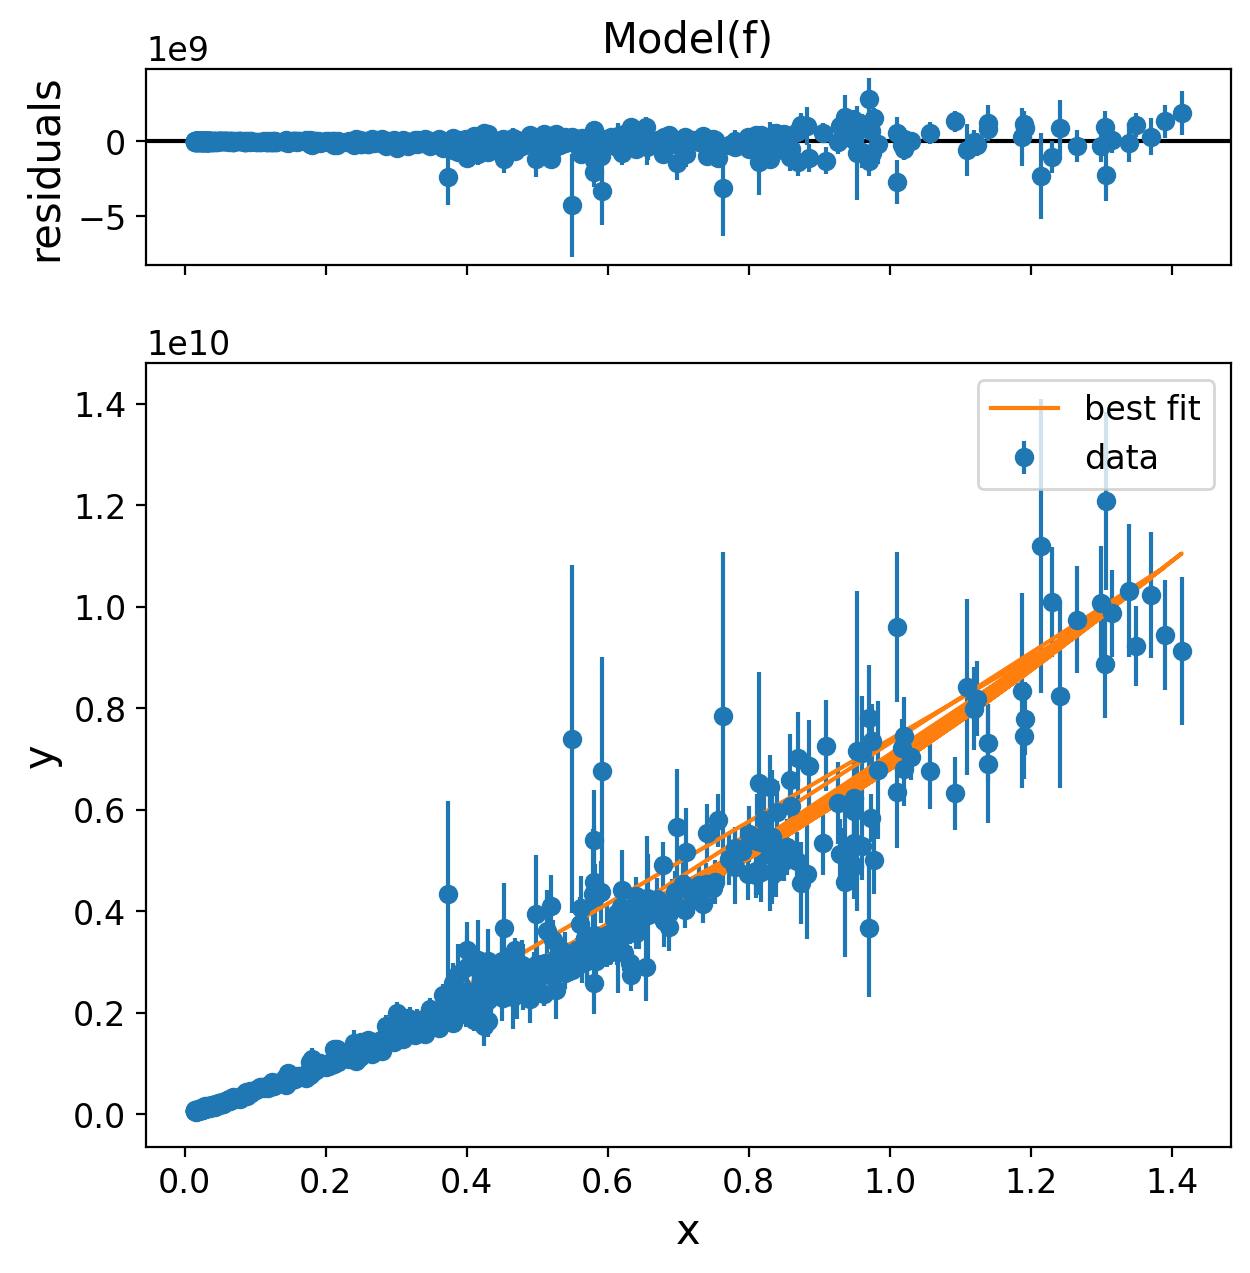

In [32]:
#>>>RUN: L4.8-runcell01

import lmfit

weights=np.array([])
for pVal in distance_err:
    #weighted fits in lmfit require you to ass in 1/sigma (not 1/sigma^2
    weights = np.append(weights,1./pVal)

#Clearly that's not working so lets use an approximation to this
def f(x,h0,q):
    val=x*(1e6*3e5/h0)*(1 + ((1-q)*0.5)*x)#+np.sin(x)*(1e6*3e5/h0)*x**57
    return val

model  = lmfit.Model(f)
p = model.make_params(h0=50,q=0)
result = model.fit(data=distance, params=p, x=redshift, weights=weights)
lmfit.report_fit(result)
plt.figure()
result.plot();

<a name='exercises_4_8'></a>   

| [Top](#section_4_0) | [Restart Section](#section_4_8) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-4.8.1 Modified Hubble Fit</span>

Add a constant term to the fit, and see if the fitted parameter is consistent with zero. Your fit function should have the following form:   

$$ f(x) = c + \frac{x}{h_{0}}\left(1+\frac{1-q}{2}x\right) $$

Run the fit with this modified form. What is your value for the constant $c$ in units of megaparsecs (MPC)? How does this compare with the typical distance between galaxies?

Report your answer with precision 1e-2.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 580
    # variables        = 3
    chi-square         = 552.057684
    reduced chi-square = 0.95677242
    Akaike info crit   = -22.6378267
    Bayesian info crit = -9.54874242
    R-squared          = 1.00000000
[[Variables]]
    h0:  67.6024343 +/- 0.56511310 (0.84%) (init = 50)
    q:  -0.02740777 +/- 0.04693171 (171.24%) (init = 0)
    c:  -3968308.11 +/- 1184151.66 (29.84%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(h0, q) = -0.867
    C(h0, c) = 0.815
    C(q, c)  = -0.667


<Figure size 700x400 with 0 Axes>

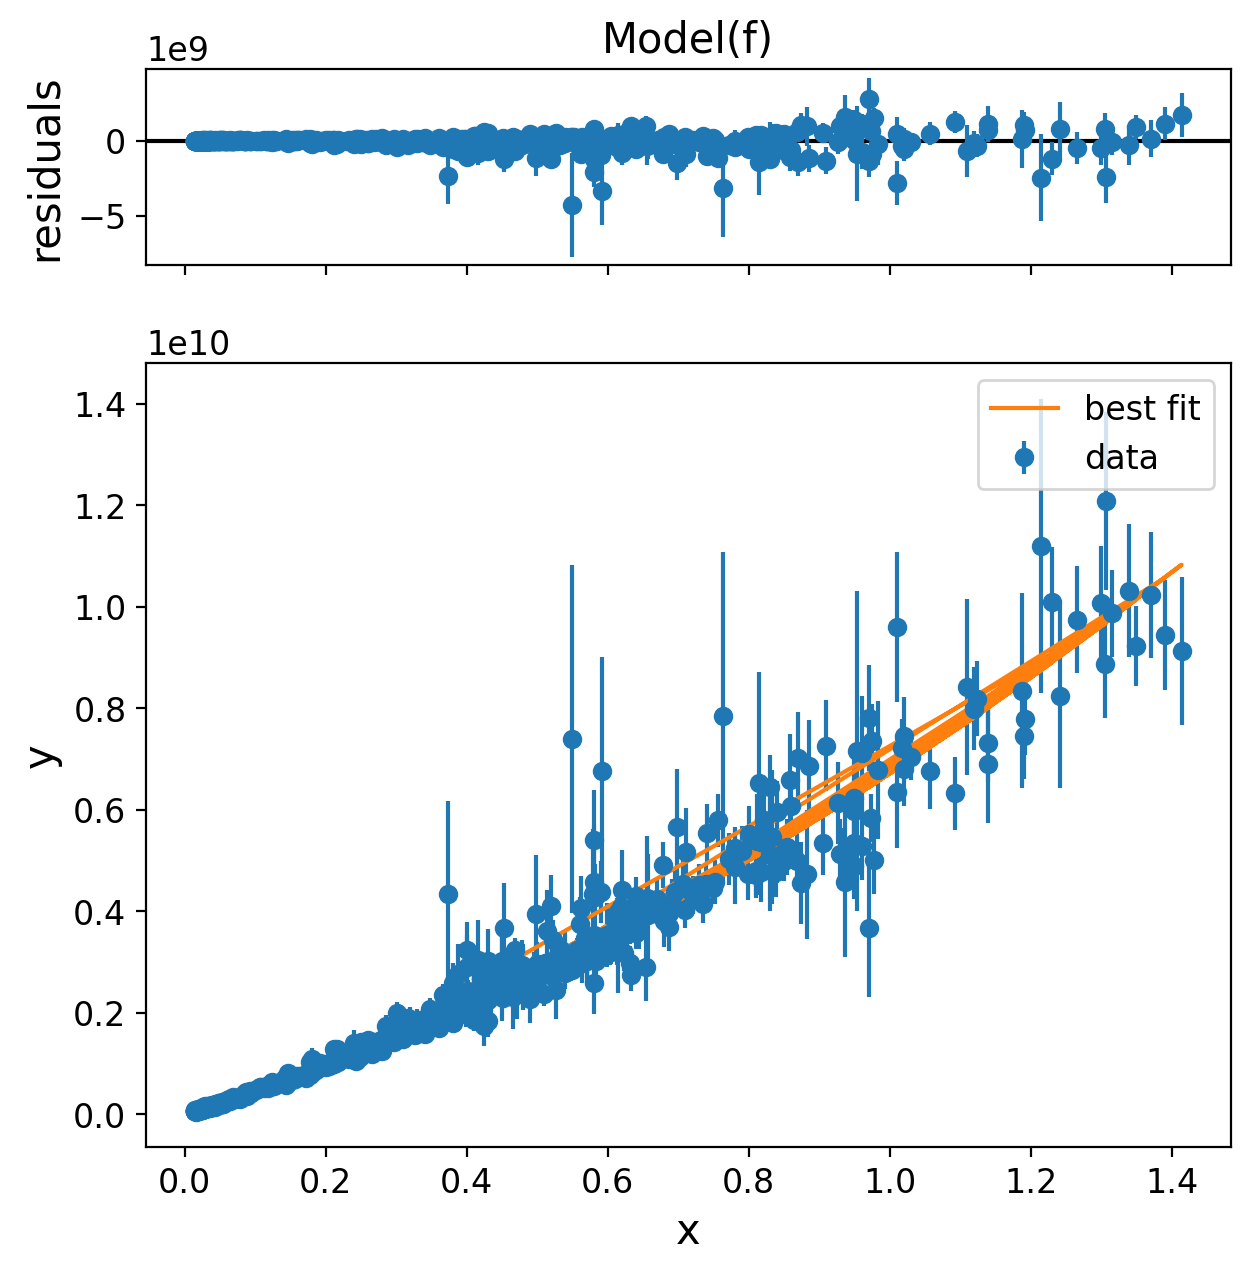

In [29]:
#>>>EXERCISE
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

def f(x,h0,q,c):
    return c+x*(1e6*3e5/h0)*(1 + ((1-q)*0.5)*x)


###FILL IN THE CODE BELOW###

#model = #YOUR CODE HERE
#p = #YOUR CORE HERE 

model  = lmfit.Model(f)
p = model.make_params(h0=50,q=0,c=0)

######

model  = lmfit.Model(f)
p = model.make_params(h0=50,q=0,c=0)

result = model.fit(data=distance, params=p, x=redshift, weights=weights)
lmfit.report_fit(result)
plt.figure()
result.plot();


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 580
    # variables        = 3
    chi-square         = 552.057684
    reduced chi-square = 0.95677242
    Akaike info crit   = -22.6378267
    Bayesian info crit = -9.54874242
[[Variables]]
    h0:  67.6024352 +/- 0.56508895 (0.84%) (init = 50)
    q:  -0.02740786 +/- 0.04693069 (171.23%) (init = 0)
    c:  -3.96830641 +/- 1.18415111 (29.84%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(h0, q) = -0.867
    C(h0, c) =  0.815
    C(q, c)  = -0.667


<Figure size 432x288 with 0 Axes>

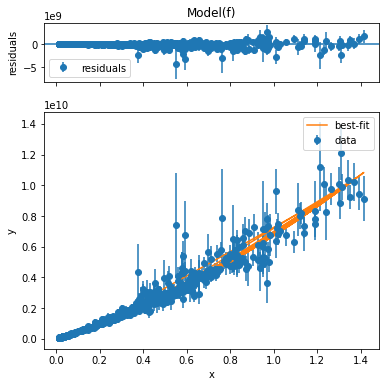

In [12]:
#>>>SOLUTION

def f(x,h0,q,c):
    val=c*1e6+x*(1e6*3e5/h0)*(1 + ((1-q)*0.5)*x)
    return val

model  = lmfit.Model(f)
p = model.make_params(h0=50,q=0,c=0)

result = model.fit(data=distance, params=p, x=redshift, weights=weights)
lmfit.report_fit(result)
plt.figure()
result.plot();


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
-3.968308
</pre>
        
**EXPLANATION:**
    
Use the code below to obtain the new fit:
    
<pre>
def f(x,h0,q,c):
    val=c+x*(1e6*3e5/h0)*(1 + ((1-q)*0.5)*x)
    return val

model  = lmfit.Model(f)
p = model.make_params(h0=50,q=0,c=0)
result = model.fit(data=distance, params=p, x=redshift, weights=weights)
lmfit.report_fit(result)
plt.figure()
result.plot();
</pre>
    
In this equation, the parameter `c` has units of parsecs. We should divide by $10^6$ to get units of MPC. The fact that this is not zero is pointing to a deeper feature about our model in that it is not full expressive, since from a physics stand point we expect that c shouldbe 0 as $x$ goes to zero. This means our descriptive equation doesn't capture all of the info that data is trying to tell us. 

</div>


<a name='section_5_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L5.1 What Do We Call Uncertainty?</h2>  

| [Top](#section_5_0) | [Previous Section](#section_5_0) | [Exercises](#exercises_5_1) | [Next Section](#section_5_2) |


<h3>Slides</h3>

Run the code below to view the slides for this section, which are discussed in the related video. You can also open the slides in a separate window <a href="https://mitx-8s50.github.io/slides/L05/slides_L05_01.html" target="_blank">HERE</a>.

In [ ]:
#>>>RUN: L5.1-slides

from IPython.display import IFrame
IFrame(src='https://mitx-8s50.github.io/slides/L05/slides_L05_01.html', width=970, height=550)

<h3>Slides</h3>

View the slides for this section below, which are discussed in the related video. You can also open the slides in a separate window <a href="https://mitx-8s50.github.io/slides/L05/slides_L05_01.html" target="_blank">HERE</a>.

<p align="center">
<iframe src="https://mitx-8s50.github.io/slides/L05/slides_L05_01.html" width="900", height="550" frameBorder="0"/>
</p>

<h3>What are Fit Residuals?</h3>

In the last Lesson, we fit the supernovae data, and got a pretty good fit for Hubble's constant. However, we didn't really try to understand how good our fit was, nor did we try to extract an uncertainty on the fit parameters. To understand what is going on, let's first look at our previous fit to the supernovae data and try to understand residuals. 

Now that we have loaded and fit the data again, we would like to actually understand how good the fit is. To do that, we are going to define the residual in $y$. We can define this as 

$$
\begin{equation}
y^{resid}_{i} = f(x_{i})-y_{\rm true} = \hat{y}_{i}-y_{\rm true}
\end{equation}
$$

Alternatively, we could also divide the above by the uncertainty $\sigma$. For now, let's compute it for this data, and make a histogram.

In [ ]:
Now that we have loaded and fit the data again, we would like to actually understand how good the fit is. To do that, we are going to define the residual in $y$. We can define this as 

$$
\begin{equation}
y^{resid}_{i} = f(x_{i})-y_{\rm true} = \hat{y}_{i}-y_{\rm true}
\end{equation}
$$

Alternatively, we could also divide the above by the uncertainty $\sigma$. For now, let's compute it for this data, and make a histogram.#>>>RUN: L5.1-runcell03

from scipy import stats

def residual(func,args,distance,distance_err=[]):
    residuals=np.array([])
    for i0 in range(len(redshift)):
        pResid=func(redshift[i0],args[0],args[1])-distance[i0]
        if len(distance_err) > 0:      
            pResid=pResid/distance_err[i0]
        residuals = np.append(residuals,pResid)
    return residuals

#This time we are going to look at a histogram of the residuals
def plotHist(residuals):
    y0, bin_edges = np.histogram(residuals, bins=30)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    norm0=len(residuals)*(bin_edges[-1]-bin_edges[0])/30.
    plt.errorbar(bin_centers,y0/norm0,yerr=y0**0.5/norm0,marker='.',drawstyle = 'steps-mid')
    
    #for good measure, let's compare this to a gaussian distribution
    k=np.linspace(bin_edges[0],bin_edges[-1],100)
    normal=stats.norm.pdf(k,0,residuals.std())
    plt.plot(k,normal,'o-')
    plt.xlabel("y$_{residual}$")
    plt.ylabel("probability")
    plt.show()
residuals=residual(linear,[A,b],distance)
plotHist(residuals)

So, you can see that our residual distribution looks somewhat like a normal (Gaussian) distribution. As a reminder, here is the analytic form of the normal distribution. 

$$
\begin{equation}
N(x,\mu,\sigma)=\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
\end{equation}
$$


It has these very important properties, which you can derive yourselves:  

$$
\begin{equation}
E[N(x,\mu,\sigma)]=\mu \\
V[N(x,\mu,\sigma)]=\sigma^2 \\
\end{equation}
$$


Now, recall from previous Lessons that the *distribution* of the sum of random numbers sampled from any distribution converges to a Gaussian distribution in the large $N$ limit. That means that the noise (i.e., the fluctuations) when taking large enough samples from any random set of distributions should be approximately Gaussian. This is a very powerful statement, that we will use again and again. 

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-5.1.1</span>

Consider the residual distribution found above, but now divide by the uncertainty of each measurement, that is, following the formula:

$$
\begin{equation}
y^{resid}_{i} = \frac{f(x_{i})-y_{true, i}}{\sigma_{y,i}}
\end{equation}
$$

If we plot this, and it is truly Gaussian, what are the *expected* values of the mean and stdev of the normalized residual distribution? Enter your answer as a list of two numbers with precision 1e-3: `[mean, stdev]`.

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
[0,1]
</pre>
        
**EXPLANATION:**
    
The `[mean,stdev]` of this Gaussian distribution should be `[0,1]`.
    
</div>


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-5.1.2</span>

Now use the data to compute the mean and standard deviation of the distribution defined by:

$$
\begin{equation}
y^{resid}_{i} = \frac{f(x_{i})-y_{true, i}}{\sigma_{y,i}}
\end{equation}
$$

**Hint: There is an option to do this in the function that we previously defined.**

How do the actual values compare to the values of an ideal Gaussian? Enter your answers found using the data as a list of two numbers with precision 1e-3: `[mean, stdev]`.


You may wish to use the starting code below.

In [ ]:
#>>>EXERCISE
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

residuals=#YOUR CODE HERE
plotHist(residuals)

print("Ideally we should have a Gaussian with mean(residuals)=0 Instead we have",residuals.mean())
print("Ideally we should have a Gaussian with std(residuals)=1. Instead we have",residuals.std())


In [ ]:
### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-5.1.3</span>

Load the supernova data for entries up to a redshift of 0.2. You can do that by completing the line of code below. Now, compute the residuals dividing by the error, as above. What is the mean and RMS of the residuals now? Why are the residuals not a Gaussian shape? 

Enter your answer as a list of two numbers with precision 1e-3: `[mean, stdev]`.#>>>SOLUTION

residuals=residual(linear,[A,b],distance,distance_err)
plotHist(residuals)

print("Ideally we should have a Gaussian with mean(residuals)=0 Instead we have",residuals.mean())
print("Ideally we should have a Gaussian with std(residuals)=1. Instead we have",residuals.std())


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-5.1.3</span>

Load the supernova data for entries up to a redshift of 0.2. You can do that by completing the line of code below. Now, compute the residuals dividing by the error, as above. What is the mean and RMS of the residuals now? Why are the residuals not a Gaussian shape? 

Enter your answer as a list of two numbers with precision 1e-3: `[mean, stdev]`.

In [30]:
-3968308.11/1184151.66

-3.351182322372457

In [ ]:
#>>>EXERCISE
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

redshift02,distance02,distance02_err = load(label,0.2)

#Find these parameters by running the regression using regress()
A02,b02=#YOUR CODE HERE
http://localhost:8888/notebooks/8316_L04_MAIN.ipynb#
plotAll(redshift02,distance02,distance02_err,A02,b02)

#plot regression to check
residuals02=#YOUR CODE HERE
plotHist(residuals02)

print("Ideally we should have a Gaussian with mean(residuals)=0 Instead we have",residuals.mean())
print("Ideally we should have a Gaussian with std(residuals)=1. Instead we have",residuals.std())


In [ ]:
redshift02,distance02,distance02_err = load(label,0.2)
A02,b02=regress(redshift,distance)
plotAll(redshift02,distance02,distance02_err,A02,b02)

residuals02=residual(linear,[A02,b02],distance02,distance02_err)
plotHist(residuals02)

print("Ideally we should have a Gaussian with mean(residuals)=0 Instead we have",residuals02.mean())
print("Ideally we should have a Gaussian with std(residuals)=1. Instead we have",residuals02.std())

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
[2.1624047,10.581414]
</pre>
        
**EXPLANATION:**

The distribution is not Gaussian anymore because the higher redshift seems to have a non-linear dependence. This is indicative of a problem in the choice of fit function, maybe a linear dependence is not sufficient to describe the data!

</div>
